## **Merging datasets from kaggle (Jan 1 2020 to Dec 31 2023) + from govt (Jan 1 2024 to May 31 2025)**


In [ ]:
import pandas as pd
import numpy as np

# -------------------------------
# 1. Load Kaggle CSV
# -------------------------------
kaggle_df = pd.read_csv('kaggle.csv')

# -------------------------------
# 2. Load Govt Excel (skip 16 rows)
# -------------------------------
govt_df = pd.read_excel('govt.xlsx', sheet_name=0, skiprows=16)
govt_df.columns = govt_df.columns.str.strip()  # Clean up column names

# -------------------------------
# 3. Preprocess Kaggle
# -------------------------------
kaggle_df['Datetime'] = pd.to_datetime(kaggle_df['Datetime'], format='mixed', dayfirst=True, errors='coerce')
kaggle_df = kaggle_df.dropna(subset=['Datetime'])
kaggle_df = kaggle_df[kaggle_df['City'].str.lower() == 'delhi']
kaggle_df = kaggle_df.drop(columns=['City'])

# Filter for 2020–2023
kaggle_filtered = kaggle_df[(kaggle_df['Datetime'] >= '2020-01-01') & (kaggle_df['Datetime'] <= '2023-12-31')]

# -------------------------------
# 4. Preprocess Govt
# -------------------------------
govt_df['From Date'] = pd.to_datetime(govt_df['From Date'], format='mixed', dayfirst=True, errors='coerce')
govt_df = govt_df.dropna(subset=['From Date'])

govt_filtered = govt_df[(govt_df['From Date'] >= '2024-01-01') & (govt_df['From Date'] <= '2025-05-31')]
govt_filtered = govt_filtered.rename(columns={'From Date': 'Datetime', 'Ozone': 'O3'})

# Ensure missing columns exist
for col in ['NO', 'NO2', 'Benzene', 'Toluene']:
    if col not in govt_filtered.columns:
        govt_filtered[col] = np.nan

# Fill Benzene and Toluene from Kaggle (same date)
kaggle_lookup = kaggle_df.set_index('Datetime')[['Benzene', 'Toluene']]
govt_filtered.set_index('Datetime', inplace=True)
govt_filtered[['Benzene', 'Toluene']] = govt_filtered[['Benzene', 'Toluene']].fillna(
    kaggle_lookup[['Benzene', 'Toluene']]
)
govt_filtered.reset_index(inplace=True)

# -------------------------------
# 5. AQI Calculation
# -------------------------------
def calculate_sub_index(conc, breakpoints):
    for (low, high, index_low, index_high) in breakpoints:
        if pd.notnull(conc) and low <= conc <= high:
            return round(((index_high - index_low) / (high - low)) * (conc - low) + index_low, 1)
    return None

def calculate_aqi(row):
    pm25_bp = [(0,30,0,50), (31,60,51,100), (61,90,101,200),
               (91,120,201,300), (121,250,301,400), (251,500,401,500)]
    pm10_bp = [(0,50,0,50), (51,100,51,100), (101,250,101,200),
               (251,350,201,300), (351,430,301,400), (431,600,401,500)]
    nox_bp = [(0,40,0,50), (41,80,51,100), (81,180,101,200),
              (181,280,201,300), (281,400,301,400), (401,500,401,500)]
    co_bp = [(0,1,0,50), (1.1,2,51,100), (2.1,10,101,200),
             (10.1,17,201,300), (17.1,34,301,400), (34.1,50,401,500)]
    o3_bp = [(0,50,0,50), (51,100,51,100), (101,168,101,200),
             (169,208,201,300), (209,748,301,500)]

    sub_indices = [
        calculate_sub_index(row['PM2.5'], pm25_bp),
        calculate_sub_index(row['PM10'], pm10_bp),
        calculate_sub_index(row['NOx'], nox_bp),
        calculate_sub_index(row['CO'], co_bp),
        calculate_sub_index(row['O3'], o3_bp)
    ]

    sub_indices = [i for i in sub_indices if i is not None]
    return max(sub_indices) if sub_indices else None

def get_aqi_bucket(aqi):
    if aqi is None: return None
    elif aqi <= 50: return 'Good'
    elif aqi <= 100: return 'Satisfactory'
    elif aqi <= 200: return 'Moderate'
    elif aqi <= 300: return 'Poor'
    elif aqi <= 400: return 'Very Poor'
    else: return 'Severe'

# Apply to both
for df in [kaggle_filtered, govt_filtered]:
    df['AQI'] = df.apply(calculate_aqi, axis=1)
    df['AQI_Bucket'] = df['AQI'].apply(get_aqi_bucket)

# -------------------------------
# 6. Merge and Save
# -------------------------------
columns = ['Datetime', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'O3', 'Benzene', 'Toluene', 'AQI', 'AQI_Bucket']
final_kaggle = kaggle_filtered[columns]
final_govt = govt_filtered[columns]

combined_df = pd.concat([final_kaggle, final_govt], ignore_index=True)
combined_df = combined_df.sort_values('Datetime')
combined_df.to_csv('merged_delhi_aqi.csv', index=False)

print("✅ Done! Final dataset saved as 'merged_delhi_aqi.csv'")


## **Exploratory Data Analysis (EDA)**

📌 Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2495 entries, 0 to 2494
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Datetime    2495 non-null   datetime64[ns]
 1   PM2.5       1972 non-null   float64       
 2   PM10        1971 non-null   float64       
 3   NO          2487 non-null   float64       
 4   NO2         1973 non-null   float64       
 5   NOx         1973 non-null   float64       
 6   CO          1973 non-null   float64       
 7   O3          1973 non-null   float64       
 8   Benzene     2193 non-null   float64       
 9   Toluene     2193 non-null   float64       
 10  AQI         1973 non-null   float64       
 11  AQI_Bucket  2495 non-null   object        
dtypes: datetime64[ns](1), float64(10), object(1)
memory usage: 234.0+ KB
None

🧪 Missing Values:
Datetime        0
PM2.5         523
PM10          524
NO              8
NO2           522
NOx           

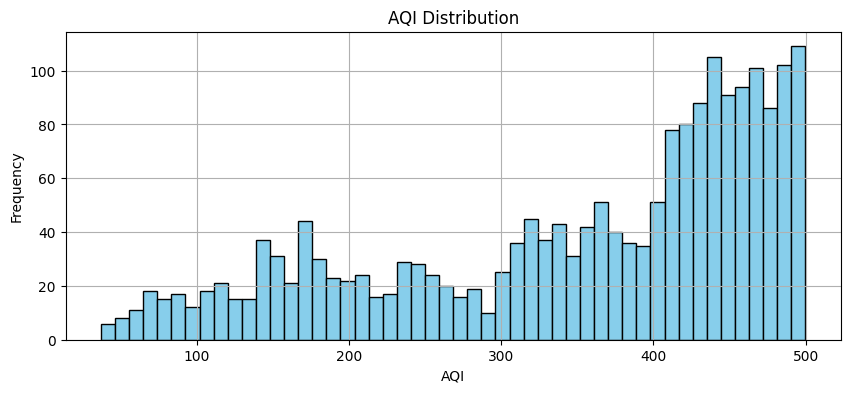


📊 AQI Bucket Counts:
AQI_Bucket
Severe          1501
Very Poor        420
Moderate         270
Poor             217
Satisfactory      78
Good               9
Name: count, dtype: int64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('merged_delhi_aqi.csv', parse_dates=['Datetime'])

# BASIC INFO
print("📌 Dataset Summary:")
print(df.info())
print("\n🧪 Missing Values:")
print(df.isnull().sum())

# DATE RANGE CHECK
print("\n📅 Date range:", df['Datetime'].min(), "→", df['Datetime'].max())

# SAMPLE DATA
print("\n📄 Sample rows:")
print(df.head())

# DUPLICATE DATES?
dup_dates = df['Datetime'].duplicated().sum()
print(f"\n🌀 Duplicate dates: {dup_dates}")

# AQI Distribution Plot
plt.figure(figsize=(10,4))
df['AQI'].plot.hist(bins=50, color='skyblue', edgecolor='black')
plt.title('AQI Distribution')
plt.xlabel('AQI')
plt.grid(True)
plt.show()

# AQI Bucket counts
print("\n📊 AQI Bucket Counts:")
print(df['AQI_Bucket'].value_counts())


## **Data cleaning & preparation**

In [ ]:
import pandas as pd

# -------------------------------
# 1. Load and sort data
# -------------------------------
df = pd.read_csv('merged_delhi_aqi.csv', parse_dates=['Datetime'])
df = df.sort_values('Datetime')

# -------------------------------
# 2. Remove duplicates by keeping the most complete row
# -------------------------------
# Add a helper column: count of non-null values
df['non_null_count'] = df.notnull().sum(axis=1)

# Keep only the row with most non-null values per date
df = df.sort_values('non_null_count', ascending=False).drop_duplicates(subset='Datetime', keep='first')

# Drop helper column
df.drop(columns='non_null_count', inplace=True)

# -------------------------------
# 3. Drop rows where key pollutants or AQI are missing
# -------------------------------
required_cols = ['PM2.5', 'PM10', 'NOx', 'CO', 'O3', 'AQI']
df_clean = df.dropna(subset=required_cols)

# -------------------------------
# 4. Save the cleaned dataset
# -------------------------------
df_clean.to_csv('cleaned_delhi_aqi.csv', index=False)
print("✅ Cleaned dataset saved as 'cleaned_delhi_aqi.csv'")
print("🔍 Final shape:", df_clean.shape)


✅ Cleaned dataset saved as 'cleaned_delhi_aqi.csv'
🔍 Final shape: (1971, 12)


In [ ]:
import pandas as pd

# -------------------------------
# 1. Load cleaned dataset
# -------------------------------
df = pd.read_csv('cleaned_delhi_aqi.csv', parse_dates=['Datetime'])
df = df.sort_values('Datetime')

# -------------------------------
# 2. Create missingness indicator columns
# -------------------------------
df['Benzene_missing'] = df['Benzene'].isnull().astype(int)
df['Toluene_missing'] = df['Toluene'].isnull().astype(int)

# -------------------------------
# 3. Impute with forward fill (preserve temporal continuity)
# -------------------------------
df['Benzene'] = df['Benzene'].fillna(method='ffill')
df['Toluene'] = df['Toluene'].fillna(method='ffill')

# -------------------------------
# 4. Fill any remaining top-level NaNs with mean (safe fallback)
# -------------------------------
df['Benzene'] = df['Benzene'].fillna(df['Benzene'].mean())
df['Toluene'] = df['Toluene'].fillna(df['Toluene'].mean())

# -------------------------------
# 5. Save preprocessed dataset
# -------------------------------
df.to_csv('preprocessed_for_hybrid_dl.csv', index=False)
print("✅ Preprocessed dataset saved as 'preprocessed_for_hybrid_dl.csv'")


✅ Preprocessed dataset saved as 'preprocessed_for_hybrid_dl.csv'


<ipython-input-3-061fabf081c8>:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Benzene'] = df['Benzene'].fillna(method='ffill')
<ipython-input-3-061fabf081c8>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Toluene'] = df['Toluene'].fillna(method='ffill')


In [ ]:
# Safest and cleanest option:
df_clean['NO'] = df_clean['NO'].fillna(method='ffill')


<ipython-input-6-e4df10504e52>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_clean['NO'] = df_clean['NO'].fillna(method='ffill')


In [ ]:
df_clean.to_csv('final_preprocessed_for_dl.csv', index=False)
print("✅ Final version saved with NO imputed.")


✅ Final version saved with NO imputed.


In [ ]:
# Load the final preprocessed dataset (if not already loaded)
df_clean = pd.read_csv('final_preprocessed_for_dl.csv', parse_dates=['Datetime'])

# Print the date range
print("📅 Cleaned date range:", df_clean['Datetime'].min(), "→", df_clean['Datetime'].max())

# Print count of missing values per column
print("🧪 Remaining missing values:\n", df_clean.isnull().sum())


📅 Cleaned date range: 2020-01-01 00:00:00 → 2025-05-31 00:00:00
🧪 Remaining missing values:
 Datetime           0
PM2.5              0
PM10               0
NO                 0
NO2                0
NOx                0
CO                 0
O3                 0
Benzene            0
Toluene            0
AQI                0
AQI_Bucket         0
Benzene_missing    0
Toluene_missing    0
dtype: int64


**Save dataset as "Delhi_monthly.csv"**

## **Data pre-processing**

**MinMaxScaler**

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib

# Load your dataset
delhi_data = pd.read_csv('Delhi_monthly.csv', parse_dates=['Datetime'])

# Define columns to scale
scale_cols = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'O3', 'Benzene', 'Toluene']

# Initialize and fit scaler
scaler = MinMaxScaler()
delhi_data[scale_cols] = scaler.fit_transform(delhi_data[scale_cols])

# Save scaler for inverse_transform later (optional)
joblib.dump(scaler, 'scaler.pkl')

# Save scaled dataset to CSV
delhi_data.to_csv('scaled_for_sequences.csv', index=False)

print("✅ Scaled data saved to 'scaled_for_sequences.csv'")
print("✅ Scaler saved to 'scaler.pkl'")


✅ Scaled data saved to 'scaled_for_sequences.csv'
✅ Scaler saved to 'scaler.pkl'


this gives the scaled and preprocessed data for AQI prediction

## **Run From here**

Download the scaled file and proceed to run from here ->

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# Load the scaled dataset
df = pd.read_csv('scaled_for_sequences.csv', parse_dates=['Datetime'])

# Features and target
features = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'O3', 'Benzene', 'Toluene',
            'Benzene_missing', 'Toluene_missing']
target = 'AQI'


In [ ]:
print("✅ Columns in scaled file:")
print(df.columns.tolist())

print("📦 Sample features shape:", df[features].shape)
print("🎯 Target preview:", df[target].head())


✅ Columns in scaled file:
['Datetime', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'O3', 'Benzene', 'Toluene', 'AQI', 'AQI_Bucket', 'Benzene_missing', 'Toluene_missing']
📦 Sample features shape: (1971, 11)
🎯 Target preview: 0    483.2
1    340.1
2    292.8
3    444.6
4    420.2
Name: AQI, dtype: float64


In [ ]:
import numpy as np

def create_sequences(data, feature_cols, target_col, sequence_length=12):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[feature_cols].iloc[i:i+sequence_length].values)
        y.append(data[target_col].iloc[i+sequence_length])
    return np.array(X), np.array(y)


In [ ]:
# Set your sequence length
sequence_length = 12

# Load dataset
import pandas as pd
df = pd.read_csv('scaled_for_sequences.csv', parse_dates=['Datetime'])

# Define features and target
features = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'O3', 'Benzene', 'Toluene',
            'Benzene_missing', 'Toluene_missing']
target = 'AQI'

# Generate sequences
X, y = create_sequences(df, features, target, sequence_length=sequence_length)

# Train/Val/Test Split (e.g., 70/20/10)
train_size = int(0.7 * len(X))
val_size = int(0.2 * len(X))
test_size = len(X) - train_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

print("✅ Shapes:")
print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)


✅ Shapes:
Train: (1371, 12, 11) (1371,)
Val:   (391, 12, 11) (391,)
Test:  (197, 12, 11) (197,)


In [ ]:
df = pd.read_csv('scaled_for_sequences.csv')

print("Number of records:", len(df))

Number of records: 1971


# Feature selection

# 1. correlational analysis

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Load the dataset
data = pd.read_csv('scaled_for_sequences.csv')

# Select features and target
features = data[['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'O3', 'Benzene', 'Toluene']]
target = data['AQI']

# Combine features and target for correlation analysis
correlation_data = features.copy()
correlation_data['AQI'] = target

# Calculate correlation matrix
correlation_matrix = correlation_data.corr()

In [ ]:
# Display correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
            PM2.5      PM10        NO       NO2       NOx        CO        O3  \
PM2.5    1.000000  0.179462  0.282154  0.249976  0.266269  0.271562  0.237468   
PM10     0.179462  1.000000  0.176018  0.117898  0.150548  0.115583  0.135330   
NO       0.282154  0.176018  1.000000  0.330753  0.356251  0.334330  0.312711   
NO2      0.249976  0.117898  0.330753  1.000000  0.313243  0.322730  0.297050   
NOx      0.266269  0.150548  0.356251  0.313243  1.000000  0.341205  0.272189   
CO       0.271562  0.115583  0.334330  0.322730  0.341205  1.000000  0.315891   
O3       0.237468  0.135330  0.312711  0.297050  0.272189  0.315891  1.000000   
Benzene  0.045698  0.030237  0.055996  0.038340  0.000621  0.063341  0.048945   
Toluene  0.065847  0.043796  0.106072  0.074275  0.056901  0.072299  0.082214   
AQI      0.781414  0.507493  0.416981  0.377513  0.415229  0.394496  0.369109   

          Benzene   Toluene       AQI  
PM2.5    0.045698  0.065847  0.781414  
PM10    

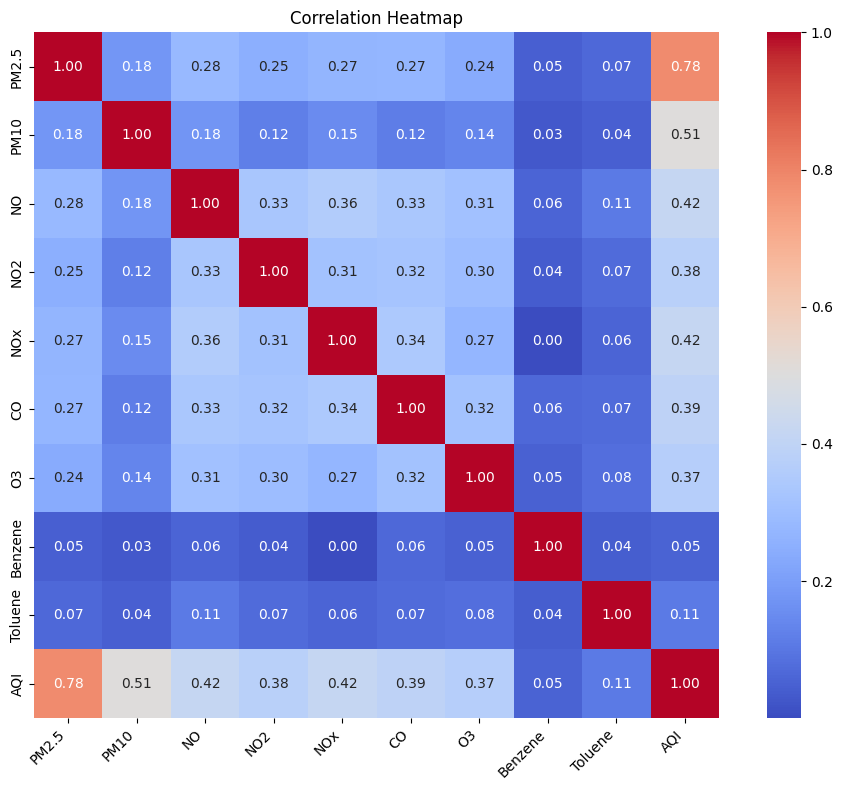

In [ ]:
# Visualize correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Correlation Heatmap")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()




---
correlational analysis clearly shows that benzene and toluene show the least correlation with AQI and can be said to have less impact on its change.



---

# 2. Lasso Regularization

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import pandas as pd

# Load the dataset
data = pd.read_csv('scaled_for_sequences.csv', parse_dates=['Datetime'])

# Check for missing values and handle them if needed
if data.isnull().sum().any():
    print("Missing values detected. Handling them...")
    data.fillna(data.mean(), inplace=True)  # Fill missing values with column mean

# Prepare features and target variable
features = data[['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'O3', 'Benzene', 'Toluene']]
target = data['AQI']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Lasso Regression
lasso_model = Lasso(alpha=0.8, random_state=42) # <--- modify the alpha value to control strength of lasso
lasso_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_lasso = lasso_model.predict(X_test)

# Calculate RMSE
try:
    # If scikit-learn supports squared=False
    rmse_lasso = mean_squared_error(y_test, y_pred_lasso, squared=False)
except TypeError:
    # Manual calculation for older scikit-learn versions
    mse_lasso = mean_squared_error(y_test, y_pred_lasso)
    rmse_lasso = mse_lasso ** 0.5

print(f"RMSE (Lasso Regression): {rmse_lasso}")


RMSE (Lasso Regression): 50.90541161411084





---
alpha = Regularization parameter controlling the strength of Lasso. Smaller values allow more features, while larger values shrink coefficients aggressively.



---

* RMSE for alpha 0.01 = 50.267786580740456
* RMSE for alpha 0.05 = 50.28092428093257
* RMSE for alpha 0.1 = 50.300152280835576 ( removes benzene )
* RMSE for alpha 0.8 = 50.90541161411084 ( removes benzene and toulene )


---





> baseline RMSE and cross validation --->



In [ ]:
from sklearn.metrics import mean_squared_error

# Baseline model
y_baseline = y_test.mean()
rmse_baseline = mean_squared_error(y_test, [y_baseline] * len(y_test))**0.5
print(f"Baseline RMSE: {rmse_baseline}")


Baseline RMSE: 126.11004233001482


In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

cv_scores = cross_val_score(lasso_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
print(f"Average RMSE from Cross-Validation: {np.mean(-cv_scores)}")


Average RMSE from Cross-Validation: 55.49566452144334




> features selection are as follows-->



In [ ]:
# Extract feature importance from Lasso
feature_coefficients = pd.Series(lasso_model.coef_, index=features.columns)

# Select features with non-zero coefficients
selected_features = feature_coefficients[feature_coefficients != 0].index.tolist()
print("Selected Features:", selected_features)


Selected Features: ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'O3']


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import pandas as pd

# Load the dataset
data = pd.read_csv('scaled_for_sequences.csv')

# Prepare features and target variable
features = data[['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'O3', 'Benzene', 'Toluene']]
target = data['AQI']

# Remove Benzene from the dataset
features_selected = features.drop(columns=['Benzene'])

# Train-test split
X_train_selected, X_test_selected, y_train, y_test = train_test_split(
    features_selected, target, test_size=0.2, random_state=42
)

# Retrain Lasso
lasso_model_selected = Lasso(alpha=0.01, random_state=42)
lasso_model_selected.fit(X_train_selected, y_train)

# Predict and evaluate
y_pred_selected = lasso_model_selected.predict(X_test_selected)

# Compute performance metrics
rmse_selected = mean_squared_error(y_test, y_pred_selected) ** 0.5  # RMSE
mae_selected = mean_absolute_error(y_test, y_pred_selected)         # Mean Absolute Error
mape_selected = (abs((y_test - y_pred_selected) / y_test).mean()) * 100  # Mean Absolute Percentage Error
r2_selected = r2_score(y_test, y_pred_selected)                     # R-Squared

# Print metrics
print("Performance Metrics:")
print(f"RMSE: {rmse_selected:.4f}")
print(f"MAE: {mae_selected:.4f}")
print(f"MAPE: {mape_selected:.2f}%")
print(f"R-Squared: {r2_selected:.4f}")


Performance Metrics:
RMSE: 50.2500
MAE: 42.2662
MAPE: 17.42%
R-Squared: 0.8412





---
as RMSE decreases benzene is not an important factor.



---

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

# Load the dataset
data = pd.read_csv('scaled_for_sequences.csv')

# Prepare features and target variable
features = data[['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'O3', 'Benzene', 'Toluene']]
target = data['AQI']

# Remove Toluene and Benzene from the dataset
features_selected = features.drop(columns=['Benzene', 'Toluene'])

# Train-test split
X_train_selected, X_test_selected, y_train, y_test = train_test_split(
    features_selected, target, test_size=0.2, random_state=42
)

# Retrain Lasso
lasso_model_selected = Lasso(alpha=0.01, random_state=42)
lasso_model_selected.fit(X_train_selected, y_train)

# Predict and evaluate
y_pred_selected = lasso_model_selected.predict(X_test_selected)

# Compute performance metrics
rmse_selected = mean_squared_error(y_test, y_pred_selected) ** 0.5  # RMSE
mae_selected = mean_absolute_error(y_test, y_pred_selected)         # Mean Absolute Error
mape_selected = (abs((y_test - y_pred_selected) / y_test).mean()) * 100  # Mean Absolute Percentage Error
r2_selected = r2_score(y_test, y_pred_selected)                     # R-Squared

# Print metrics
print("Performance Metrics:")
print(f"RMSE: {rmse_selected:.4f}")
print(f"MAE: {mae_selected:.4f}")
print(f"MAPE: {mape_selected:.2f}%")
print(f"R-Squared: {r2_selected:.4f}")



Performance Metrics:
RMSE: 50.4364
MAE: 42.3606
MAPE: 17.48%
R-Squared: 0.8400






---
as rmse increases on removal of toluene , it does influence AQI to an extent.





---

# 3. Random Forest Regression:

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

# Load the dataset
data = pd.read_csv('scaled_for_sequences.csv')

# Prepare features and target variable
features = data[['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'O3', 'Benzene', 'Toluene']]
target = data['AQI']

# Remove Benzene from the dataset
features_selected = features.drop(columns=['Benzene'])

# Train-test split
X_train_selected, X_test_selected, y_train, y_test = train_test_split(
    features_selected, target, test_size=0.2, random_state=42
)

# Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_selected, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test_selected)

# Compute performance metrics
rmse_rf = mean_squared_error(y_test, y_pred_rf) ** 0.5  # RMSE
mae_rf = mean_absolute_error(y_test, y_pred_rf)         # Mean Absolute Error
mape_rf = (abs((y_test - y_pred_rf) / y_test).mean()) * 100  # Mean Absolute Percentage Error
r2_rf = r2_score(y_test, y_pred_rf)                     # R-Squared

# Print metrics
print("Performance Metrics for Random Forest:")
print(f"RMSE: {rmse_rf:.4f}")
print(f"MAE: {mae_rf:.4f}")
print(f"MAPE: {mape_rf:.2f}%")
print(f"R-Squared: {r2_rf:.4f}")


Performance Metrics for Random Forest:
RMSE: 6.9450
MAE: 2.5822
MAPE: 1.31%
R-Squared: 0.9970




---
* Low Errors: Both RMSE (6.9450) and MAE (2.5822) indicate minimal prediction errors, especially given the typical AQI range.

* High Accuracy: A MAPE of 1.31% suggests the model is highly accurate and consistent.

* Excellent Fit: An R-Squared value of 0.9970 confirms that the model explains almost all variability in AQI values based on the input features.
---

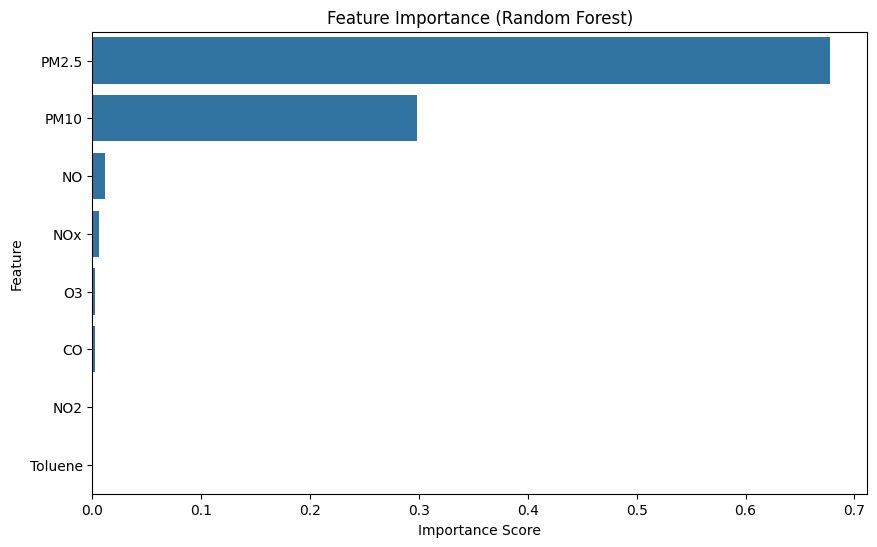

   Feature  Importance
0    PM2.5    0.677940
1     PM10    0.298713
2       NO    0.011603
4      NOx    0.006345
6       O3    0.002470
5       CO    0.002248
3      NO2    0.000370
7  Toluene    0.000312


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importance
importance = rf_model.feature_importances_
feature_names = features_selected.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

# Print feature importance
print(importance_df)


---
choosing threshold on the basis of pre existing knowledge regarding correlation of AQI and pollutants


---

In [ ]:
# Set a threshold for importance
threshold = 0.001
relevant_features = importance_df[importance_df['Importance'] >= threshold]['Feature'].tolist()

# Print relevant features
print("\nRelevant Features Selected:")
print(relevant_features)

# Update features with only relevant ones
features_relevant = features_selected[relevant_features]

# Train-test split with relevant features
X_train_relevant, X_test_relevant, y_train, y_test = train_test_split(
    features_relevant, target, test_size=0.2, random_state=42
)

# Retrain Random Forest with relevant features
rf_model_relevant = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_relevant.fit(X_train_relevant, y_train)

# Predict and evaluate
y_pred_relevant = rf_model_relevant.predict(X_test_relevant)

# Compute performance metrics
rmse_relevant = mean_squared_error(y_test, y_pred_relevant) ** 0.5  # RMSE
mae_relevant = mean_absolute_error(y_test, y_pred_relevant)         # MAE
mape_relevant = (abs((y_test - y_pred_relevant) / y_test).mean()) * 100  # MAPE
r2_relevant = r2_score(y_test, y_pred_relevant)                     # R²

# Print performance metrics
print(f"\nPerformance Metrics with Relevant Features:")
print(f"RMSE: {rmse_relevant:.4f}")
print(f"MAE: {mae_relevant:.4f}")
print(f"MAPE: {mape_relevant:.2f}%")
print(f"R-Squared: {r2_relevant:.4f}")


Relevant Features Selected:
['PM2.5', 'PM10', 'NO', 'NOx', 'O3', 'CO']

Performance Metrics with Relevant Features:
RMSE: 6.5904
MAE: 2.4028
MAPE: 1.21%
R-Squared: 0.9973




---
hence toluene and NO2 can be removed from consideration.

Relevant Features Selected:
['PM2.5', 'PM10', 'NO', 'NOx', 'O3', 'CO']



---

# 4. SVM (Support Vector Machine) Regressor:

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd


In [ ]:
# Load the dataset
data = pd.read_csv('scaled_for_sequences.csv')

# Prepare features and target variable
features = data[['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'O3', 'Benzene', 'Toluene']]
target = data['AQI']

# Remove Benzene from the dataset
features_selected = features.drop(columns=['Benzene'])

# Scale features using StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_selected)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, target, test_size=0.2, random_state=42
)


In [ ]:
# Train SVM Regressor
svm_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svm_model.fit(X_train, y_train)


SVR()

In [ ]:
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.5, 1],
    'kernel': ['linear', 'rbf']
}

# Perform GridSearchCV
grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Use the best model
svm_model_best = grid_search.best_estimator_


Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters: {'C': 100, 'epsilon': 1, 'kernel': 'rbf'}


In [ ]:
# Predict on test data
y_pred = svm_model_best.predict(X_test)

# Compute performance metrics
rmse = mean_squared_error(y_test, y_pred) ** 0.5  # RMSE
mae = mean_absolute_error(y_test, y_pred)        # MAE
mape = (abs((y_test - y_pred) / y_test).mean()) * 100  # MAPE
r2 = r2_score(y_test, y_pred)                    # R²

# Print performance metrics
print(f"\nPerformance Metrics (SVM Regressor with Best Parameters):")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R-Squared: {r2:.4f}")



Performance Metrics (SVM Regressor with Best Parameters):
RMSE: 18.1653
MAE: 12.0888
MAPE: 5.10%
R-Squared: 0.9793


In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

# Load dataset
data = pd.read_csv('scaled_for_sequences.csv')

# Prepare features and target variable
features = data[['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'O3', 'Benzene', 'Toluene']]
target = data['AQI']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize SVM with RBF kernel
svr_rbf = SVR(kernel='rbf', C=100, epsilon=1) # <--- taking values from the best parameter assessment

# Recursive Feature Elimination (Simulated)
feature_names = list(features.columns)
selected_features = feature_names[:]  # Start with all features
min_rmse = float('inf')
best_features = selected_features[:]

print("Starting Feature Selection...")
for i in range(len(feature_names), 0, -1):
    # Train the model on the current feature subset
    X_train_subset = X_train[selected_features]
    X_test_subset = X_test[selected_features]

    svr_rbf.fit(X_train_subset, y_train)

    # Predict and calculate RMSE
    y_pred = svr_rbf.predict(X_test_subset)
    mse = mean_squared_error(y_test, y_pred)  # Compute MSE
    rmse = mse ** 0.5  # Calculate RMSE manually

    print(f"Features: {selected_features}, RMSE: {rmse}")

    # Update the best feature set
    if rmse < min_rmse:
        min_rmse = rmse
        best_features = selected_features[:]

    # Remove the least important feature (one at a time)
    if len(selected_features) > 1:
        feature_to_remove = selected_features.pop()

# Display the best feature set
print(f"Best Features: {best_features}")
print(f"Minimum RMSE: {min_rmse}")

# Train final SVM with the best feature set
final_X_train = X_train[best_features]
final_X_test = X_test[best_features]

svr_rbf.fit(final_X_train, y_train)
final_y_pred = svr_rbf.predict(final_X_test)
final_rmse = mean_squared_error(y_test, final_y_pred) ** 0.5  # Compute RMSE manually

print(f"Final RMSE with Best Features: {final_rmse}")


Starting Feature Selection...
Features: ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'O3', 'Benzene', 'Toluene'], RMSE: 21.89897504977403
Features: ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'O3', 'Benzene'], RMSE: 20.594187760517926
Features: ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'O3'], RMSE: 18.92788258887062
Features: ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO'], RMSE: 17.9386173983706
Features: ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx'], RMSE: 16.124435342955053
Features: ['PM2.5', 'PM10', 'NO', 'NO2'], RMSE: 16.37688404410545
Features: ['PM2.5', 'PM10', 'NO'], RMSE: 14.857799892540864
Features: ['PM2.5', 'PM10'], RMSE: 18.697989735879823
Features: ['PM2.5'], RMSE: 68.70761269651405
Best Features: ['PM2.5', 'PM10', 'NO']
Minimum RMSE: 14.857799892540864
Final RMSE with Best Features: 14.857799892540864


# Ablation study of LSTM

---

The key hyperparameters we can evaluate in the ablation study include:

*  Number of layers
*  Number of units (neurons)
*  Activation fuction
*  Optimizer
*  Learning rate
*  Loss function
*  Epoch
*  Batch size
---

In [ ]:
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = pd.read_csv('scaled_for_sequences.csv', parse_dates=['Datetime'])

features = ['PM2.5', 'PM10', 'NO', 'NOx', 'CO', 'O3']
target = 'AQI'
X = df[features].values
y = df[target].values

train_size = int(0.7 * len(X))
val_size = int(0.2 * len(X))
test_size = len(X) - train_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

In [ ]:
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_cnn = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


**LSTM Model Configuration**

**1 LSTM layer**

32 units

ReLU activation

Adam optimizer with learning rate = 0.01

MSE loss

20 epochs

Batch size = 16



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Define the model
model_layer_1 = Sequential()
model_layer_1.add(LSTM(32, activation='relu', input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])))
model_layer_1.add(Dense(1))  # Output layer for regression (linear by default)

# Compile the model
optimizer_layer_1 = Adam(learning_rate=0.01)
model_layer_1.compile(optimizer=optimizer_layer_1, loss='mse',metrics=['mae'])

# Train the model
histor_layer_1 = model_layer_1.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=20,
    batch_size=16,
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 96109.2500 - mae: 259.3477 - val_loss: 6455.5029 - val_mae: 66.9002
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3092.6567 - mae: 43.6777 - val_loss: 10522.6982 - val_mae: 82.5207
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2649.6917 - mae: 39.1633 - val_loss: 10751.8340 - val_mae: 83.0793
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2729.3625 - mae: 39.7137 - val_loss: 10529.9570 - val_mae: 82.2455
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2933.1621 - mae: 41.7329 - val_loss: 17091.2656 - val_mae: 113.8333
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3473.3752 - mae: 45.0680 - val_loss: 9534.8691 - val_mae: 79.3682
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3011.0166 - mae: 41.2271 - val_loss: 10115.4346 - val_mae: 80.8726
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3082.2722 - mae: 41.6290 - val_loss: 12918.8604 - val_mae: 93.164

**Number of layers = 2**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Define the model with 2 LSTM layers
model_layer_2 = Sequential()
model_layer_2.add(LSTM(32, activation='relu', return_sequences=True, input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])))
model_layer_2.add(LSTM(32, activation='relu'))  # Second LSTM layer
model_layer_2.add(Dense(1))  # Output layer

# Compile the model
optimizer_layer_2 = Adam(learning_rate=0.01)
model_layer_2.compile(optimizer=optimizer_layer_2, loss='mse',metrics=['mae'])

# Train the model
history_layer_2 = model_layer_2.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=20,
    batch_size=16,
    verbose=1
)


Epoch 1/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - loss: 81683.4766 - mae: 229.7048 - val_loss: 10590.5332 - val_mae: 83.1023
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3056.8960 - mae: 42.6037 - val_loss: 11941.9248 - val_mae: 87.6381
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2888.2769 - mae: 40.6205 - val_loss: 9875.7256 - val_mae: 80.7197
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3146.5608 - mae: 42.6969 - val_loss: 13521.7451 - val_mae: 94.1826
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2649.8223 - mae: 38.4375 - val_loss: 14210.3486 - val_mae: 99.9814
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3355.7847 - mae: 43.9569 - val_loss: 10734.4619 - val_mae: 82.4119
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2775.4326 - mae: 39.6246 - val_loss: 8766.3848 - val_mae: 77.0997
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2632.5562 - mae: 37.7905 - val_loss: 14868.5498 - val_mae: 102.439

**Number of layers = 3**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Define the model with 3 LSTM layers
model_layer_3 = Sequential()
model_layer_3.add(LSTM(32, activation='relu', return_sequences=True, input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])))
model_layer_3.add(LSTM(32, activation='relu', return_sequences=True))  # Second LSTM layer
model_layer_3.add(LSTM(32, activation='relu'))  # Third LSTM layer (no return_sequences)
model_layer_3.add(Dense(1))  # Output layer

# Compile the model
optimizer_layer_3 = Adam(learning_rate=0.01)
model_layer_3.compile(optimizer=optimizer_layer_3, loss='mse',metrics=['mae'])

# Train the model
history_layer_3 = model_layer_3.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=20,
    batch_size=16,
    verbose=1
)


Epoch 1/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - loss: 83234.0078 - mae: 237.3036 - val_loss: 13205.8506 - val_mae: 96.9359
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3460.0891 - mae: 47.2045 - val_loss: 7932.1504 - val_mae: 77.5032
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3611.1362 - mae: 48.2360 - val_loss: 9966.9736 - val_mae: 81.3323
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2942.3420 - mae: 41.1816 - val_loss: 11947.9912 - val_mae: 87.4118
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2679.8804 - mae: 39.1920 - val_loss: 11849.4248 - val_mae: 86.1151
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2763.5132 - mae: 39.1516 - val_loss: 12070.4482 - val_mae: 86.8223
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2550.9580 - mae: 37.6289 - val_loss: 13709.6650 - val_mae: 95.1233
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3009.9551 - mae: 42.8500 - val_loss: 14807.6387 - val_mae: 102.601

**Number of layers = 4**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Define the model with 4 LSTM layers
model_layer_4 = Sequential()
model_layer_4.add(LSTM(32, activation='relu', return_sequences=True, input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])))
model_layer_4.add(LSTM(32, activation='relu', return_sequences=True))  # Second LSTM layer
model_layer_4.add(LSTM(32, activation='relu', return_sequences=True))  # third LSTM layer
model_layer_4.add(LSTM(32, activation='relu'))  # fourth LSTM layer (no return_sequences)
model_layer_4.add(Dense(1))  # Output layer

# Compile the model
optimizer_layer_4 = Adam(learning_rate=0.01)
model_layer_4.compile(optimizer=optimizer_layer_4, loss='mse',metrics=['mae'])

# Train the model
history_layer_4 = model_layer_4.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=20,
    batch_size=16,
    verbose=1
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - loss: 75140.6250 - mae: 215.3376 - val_loss: 14637.3213 - val_mae: 98.0203
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 3000.7986 - mae: 42.1641 - val_loss: 11425.4756 - val_mae: 85.5598
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3381.6858 - mae: 45.5619 - val_loss: 26201.7031 - val_mae: 147.2275
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4999.9478 - mae: 55.9191 - val_loss: 11092.0713 - val_mae: 82.6568
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2517.3933 - mae: 36.3563 - val_loss: 10914.3809 - val_mae: 82.7079
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2466.4084 - mae: 36.9808 - val_loss: 14898.8057 - val_mae: 102.9267
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2408.4246 - mae: 36.7588 - val_loss: 9233.5557 - val_mae: 78.5659
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1398.4735 - mae: 28.1389 - val_loss: 6804.3110 - val_mae: 66.5775
Epoch 9

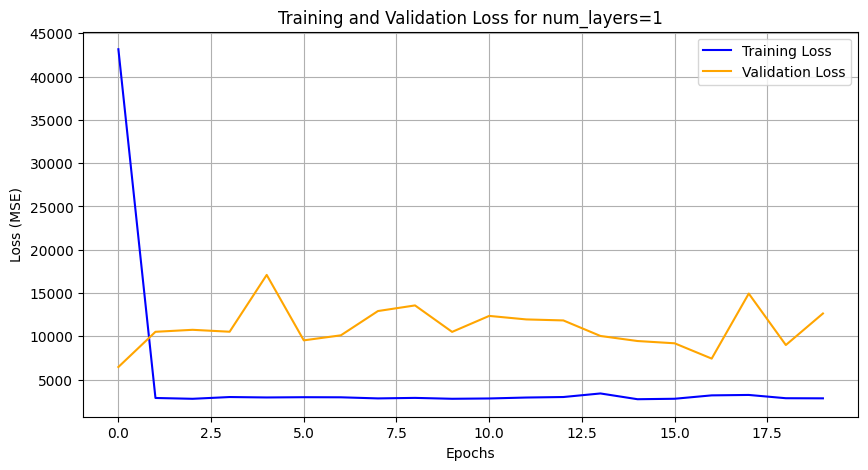

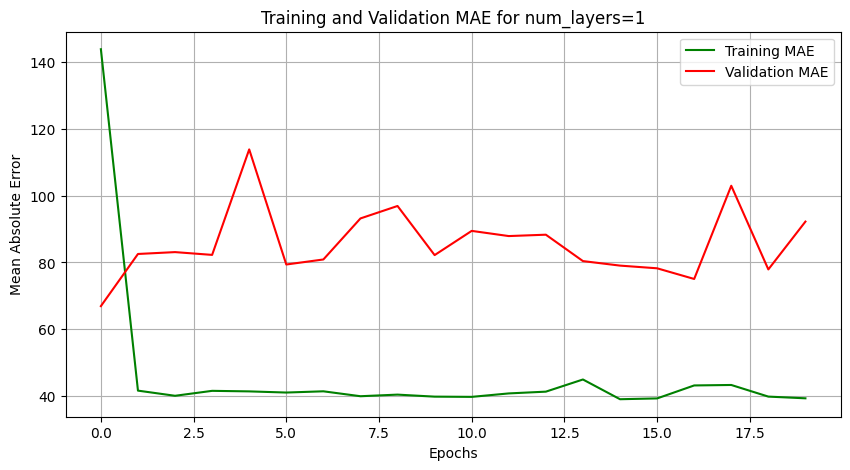

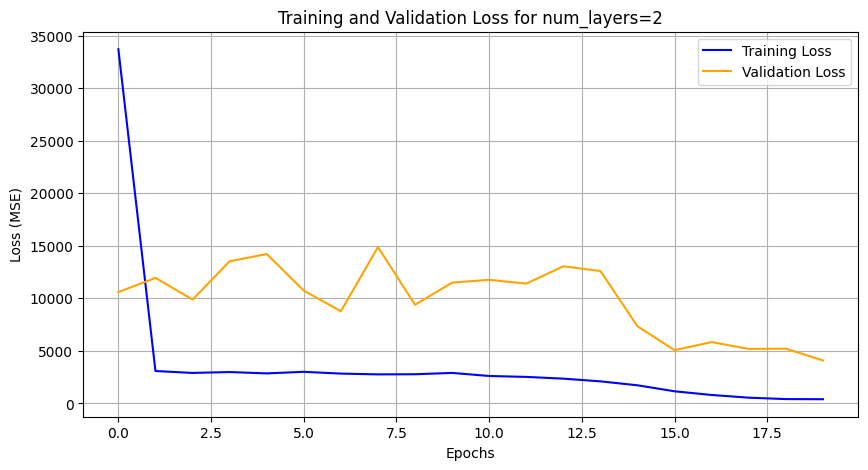

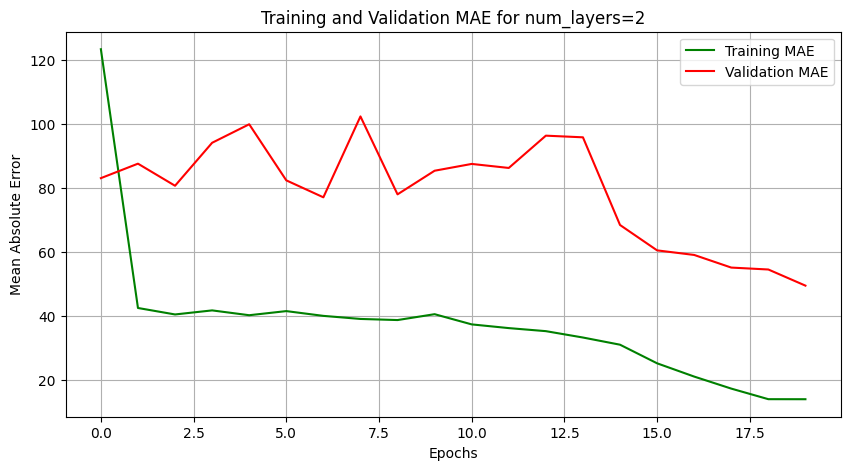

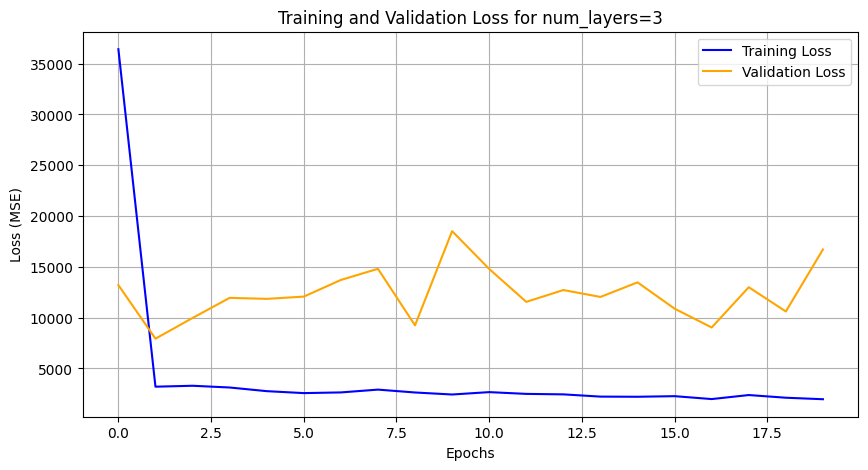

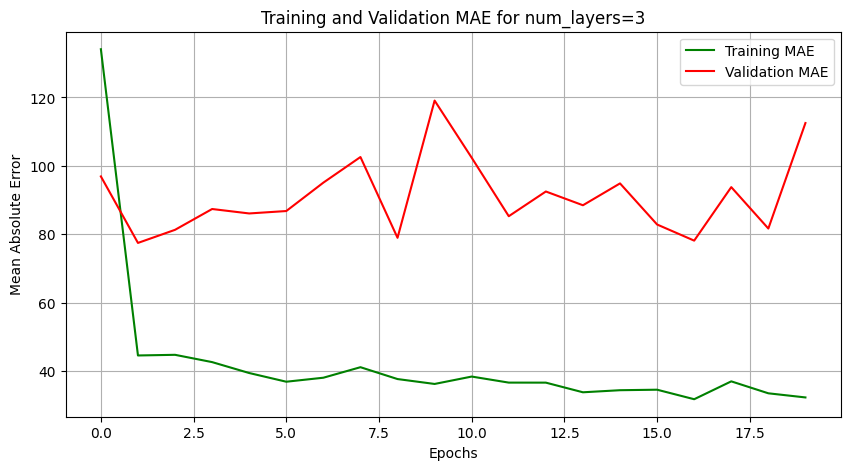

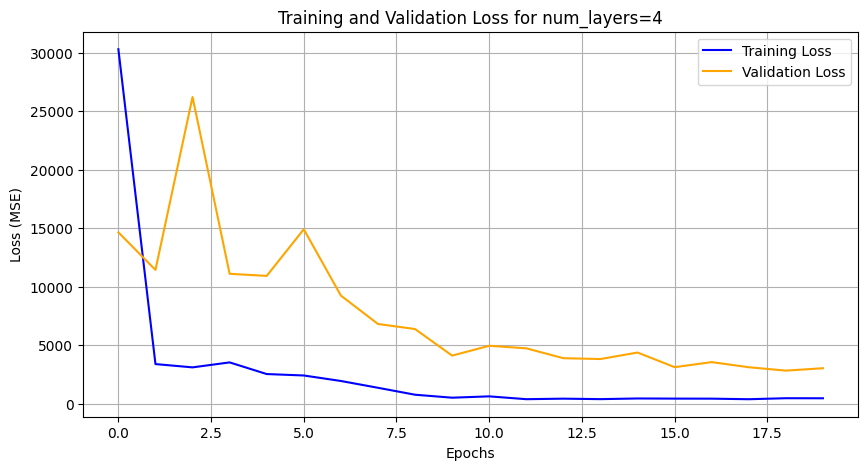

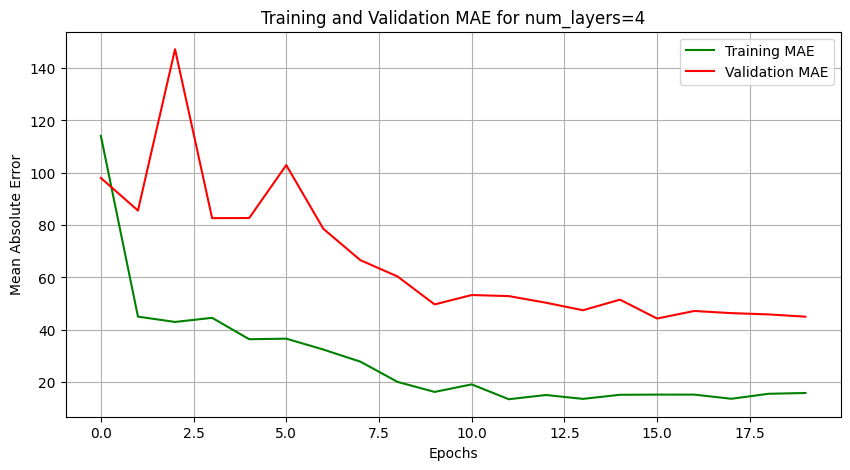

In [ ]:
import matplotlib.pyplot as plt

# List of histories and corresponding number of LSTM layers
histories = [histor_layer_1, history_layer_2, history_layer_3,history_layer_4]
num_layers = [1, 2, 3, 4]  # Update to match your actual models

for history, n in zip(histories, num_layers):
    # Plot: Loss (Train + Val)
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title(f'Training and Validation Loss for num_layers={n}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Check if MAE was tracked — only possible if you specified metrics=['mae'] during compile
    if 'mae' in history.history:
        plt.figure(figsize=(10, 5))
        plt.plot(history.history['mae'], label='Training MAE', color='green')
        plt.plot(history.history['val_mae'], label='Validation MAE', color='red')
        plt.title(f'Training and Validation MAE for num_layers={n}')
        plt.xlabel('Epochs')
        plt.ylabel('Mean Absolute Error')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print(f"⚠️ MAE metric not available for num_layers={n}. Add `metrics=['mae']` in model.compile() if needed.")


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test).flatten()

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / np.maximum(y_test, 1e-10))) * 100

    print(f"📊 {name} Metrics:")
    print(f" - R²:   {r2:.4f}")
    print(f" - RMSE: {rmse:.4f}")
    print(f" - MAE:  {mae:.4f}")
    print(f" - MAPE: {mape:.2f}%\n")

# Evaluate all three models
evaluate_model(model_layer_1, X_test_cnn, y_test, name="LSTM Model (1 Layer)")
evaluate_model(model_layer_2, X_test_cnn, y_test, name="LSTM Model (2 Layers)")
evaluate_model(model_layer_3, X_test_cnn, y_test, name="LSTM Model (3 Layers)")
evaluate_model(model_layer_4, X_test_cnn, y_test, name="LSTM Model (4 Layers)")


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step
📊 LSTM Model (1 Layer) Metrics:
 - R²:   -0.0771
 - RMSE: 111.9718
 - MAE:  90.6441
 - MAPE: 64.76%

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step
📊 LSTM Model (2 Layers) Metrics:
 - R²:   0.6119
 - RMSE: 67.2136
 - MAE:  50.7440
 - MAPE: 36.94%



7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step
📊 LSTM Model (3 Layers) Metrics:
 - R²:   -0.4539
 - RMSE: 130.0914
 - MAE:  112.6793
 - MAPE: 76.48%



7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step
📊 LSTM Model (4 Layers) Metrics:
 - R²:   0.7081
 - RMSE: 58.2923
 - MAE:  44.9973
 - MAPE: 31.23%



**Hence metrics for layer 4 LSTM is the better one. So final model will have number of layers = 4.**

**number of units = 128**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Define the model with 4 LSTM layers
model_unit_128 = Sequential()
model_unit_128.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])))
model_unit_128.add(LSTM(128, activation='relu', return_sequences=True))  # Second LSTM layer
model_unit_128.add(LSTM(128, activation='relu', return_sequences=True))  # third LSTM layer
model_unit_128.add(LSTM(128, activation='relu'))  # fourth LSTM layer (no return_sequences)
model_unit_128.add(Dense(1))  # Output layer

# Compile the model
optimizer_unit_128 = Adam(learning_rate=0.01)
model_unit_128.compile(optimizer=optimizer_unit_128, loss='mse',metrics=['mae'])

# Train the model
history_unit_128 = model_unit_128.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=20,
    batch_size=16,
    verbose=1
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


87/87 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - loss: 128564.0234 - mae: 317.5049 - val_loss: 19687.6484 - val_mae: 118.4448
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 3541.1716 - mae: 45.6282 - val_loss: 14063.9434 - val_mae: 94.6387
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2901.5337 - mae: 40.4497 - val_loss: 14353.2373 - val_mae: 96.4398
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3081.5952 - mae: 42.7804 - val_loss: 15545.1699 - val_mae: 106.1907
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3163.0566 - mae: 43.6653 - val_loss: 8292.4062 - val_mae: 80.4239
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5805.0737 - mae: 60.5069 - val_loss: 10445.8760 - val_mae: 80.9033
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3340.0723 - mae: 44.6611 - val_loss: 9424.5176 - val_mae: 79.8860
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2757.8367 - mae: 39.1792 - val_loss: 8455.1016 - val_mae: 75.3183
Epoch 9

**number of units = 64**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Define the model with 4 LSTM layers
model_unit_64 = Sequential()
model_unit_64.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])))
model_unit_64.add(LSTM(64, activation='relu', return_sequences=True))  # Second LSTM layer
model_unit_64.add(LSTM(64, activation='relu', return_sequences=True))  # third LSTM layer
model_unit_64.add(LSTM(64, activation='relu'))  # fourth LSTM layer (no return_sequences)
model_unit_64.add(Dense(1))  # Output layer

# Compile the model
optimizer_unit_64 = Adam(learning_rate=0.01)
model_unit_64.compile(optimizer=optimizer_unit_64, loss='mse',metrics=['mae'])

# Train the model
history_unit_64 = model_unit_64.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=20,
    batch_size=16,
    verbose=1
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


87/87 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - loss: 60753.4492 - mae: 186.9637 - val_loss: 11814.5381 - val_mae: 89.3810
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3692.2739 - mae: 45.8810 - val_loss: 19819.6953 - val_mae: 120.3643
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2982.7700 - mae: 41.7634 - val_loss: 15801.5059 - val_mae: 104.6185
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2803.8171 - mae: 40.2479 - val_loss: 10980.4141 - val_mae: 84.7463
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2739.1228 - mae: 39.5985 - val_loss: 9735.8477 - val_mae: 83.3967
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2914.5403 - mae: 41.0109 - val_loss: 12022.3379 - val_mae: 86.3716
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2931.3999 - mae: 42.3065 - val_loss: 10711.4756 - val_mae: 82.1511
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2433.1299 - mae: 35.7336 - val_loss: 28960.2715 - val_mae: 159.3262
Epoc

**number of units = 128,64,32,16**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Define the model with 4 LSTM layers
model_unit_mix = Sequential()
model_unit_mix.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])))
model_unit_mix.add(LSTM(64, activation='relu', return_sequences=True))  # Second LSTM layer
model_unit_mix.add(LSTM(32, activation='relu', return_sequences=True))  # third LSTM layer
model_unit_mix.add(LSTM(16, activation='relu'))  # fourth LSTM layer (no return_sequences)
model_unit_mix.add(Dense(1))  # Output layer

# Compile the model
optimizer_unit_mix = Adam(learning_rate=0.01)
model_unit_mix.compile(optimizer=optimizer_unit_mix, loss='mse',metrics=['mae'])

# Train the model
history_unit_mix = model_unit_mix.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=20,
    batch_size=16,
    verbose=1
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


87/87 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - loss: 65131.2656 - mae: 196.3000 - val_loss: 13032.2793 - val_mae: 92.0595
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3139.2051 - mae: 42.2876 - val_loss: 14703.6152 - val_mae: 102.9193
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3540.2981 - mae: 45.7676 - val_loss: 12824.1006 - val_mae: 93.0214
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2622.4299 - mae: 38.1892 - val_loss: 8543.4805 - val_mae: 75.6722
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2769.2917 - mae: 39.3531 - val_loss: 7685.5522 - val_mae: 72.6008
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3323.2571 - mae: 44.4438 - val_loss: 9257.5059 - val_mae: 77.6213
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2545.2227 - mae: 37.4876 - val_loss: 7105.0166 - val_mae: 76.4468
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3657.8230 - mae: 46.9882 - val_loss: 7082.0005 - val_mae: 75.9926
Epoch 9/20


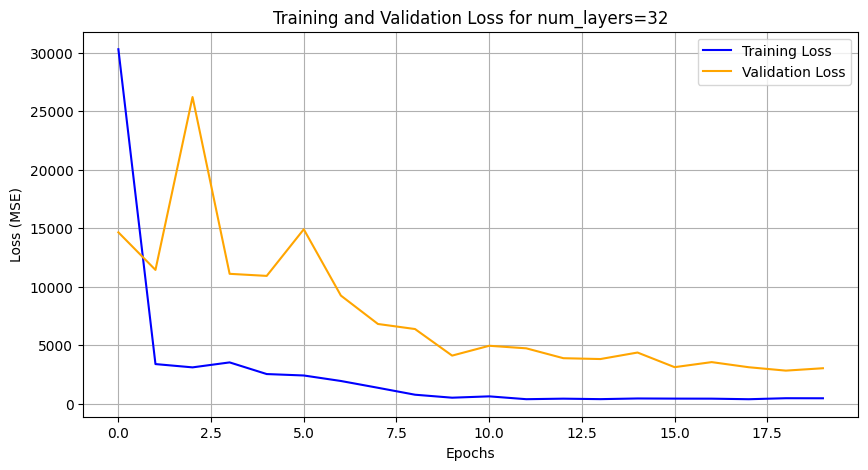

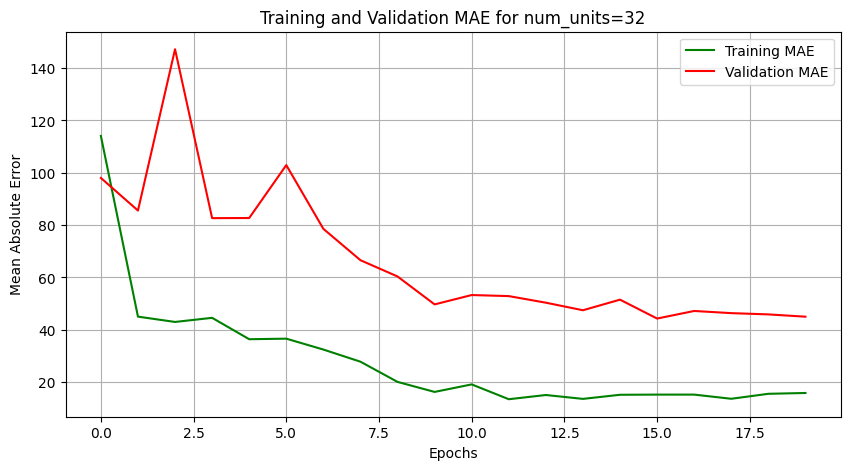

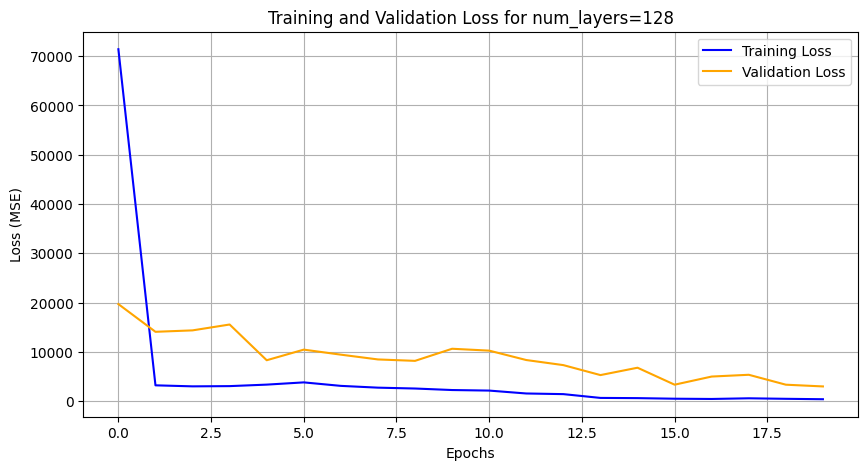

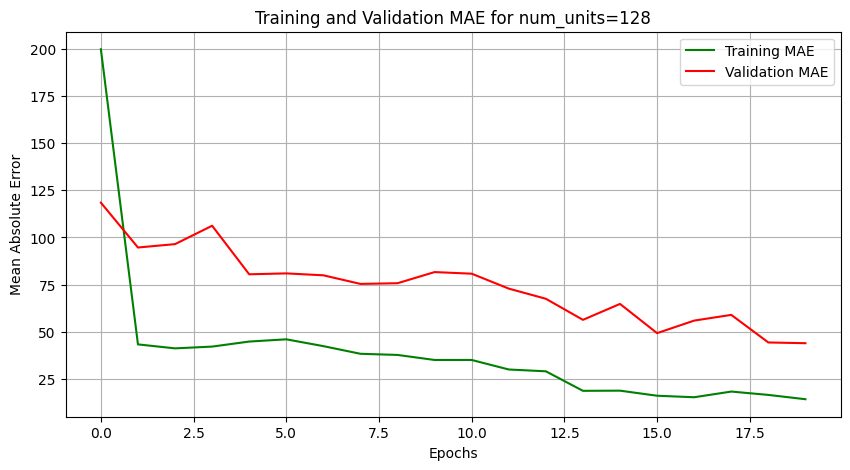

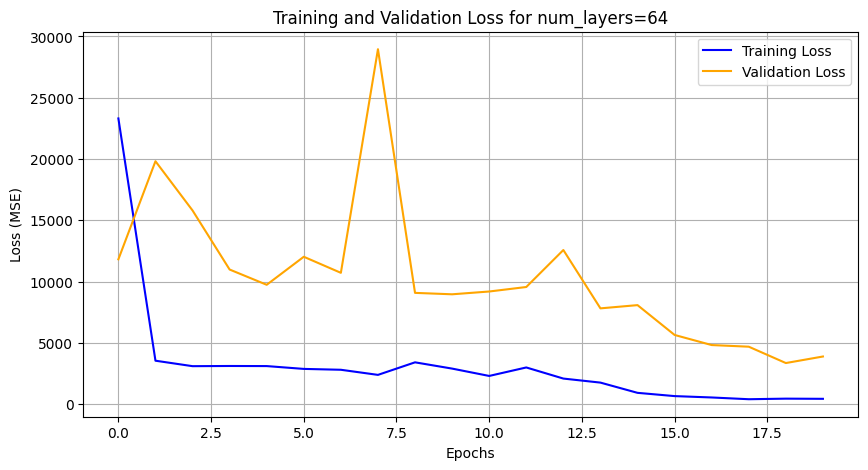

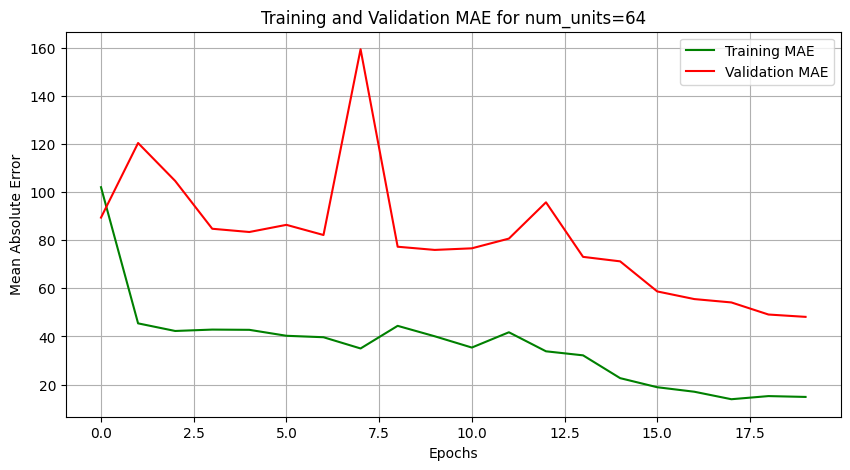

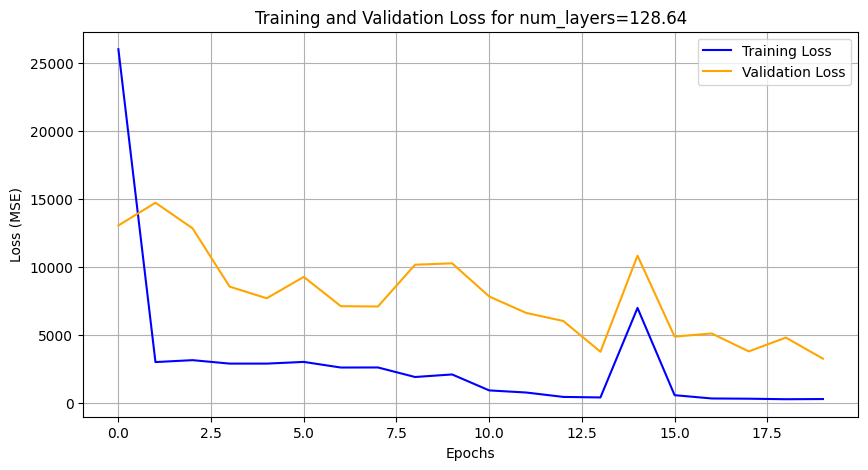

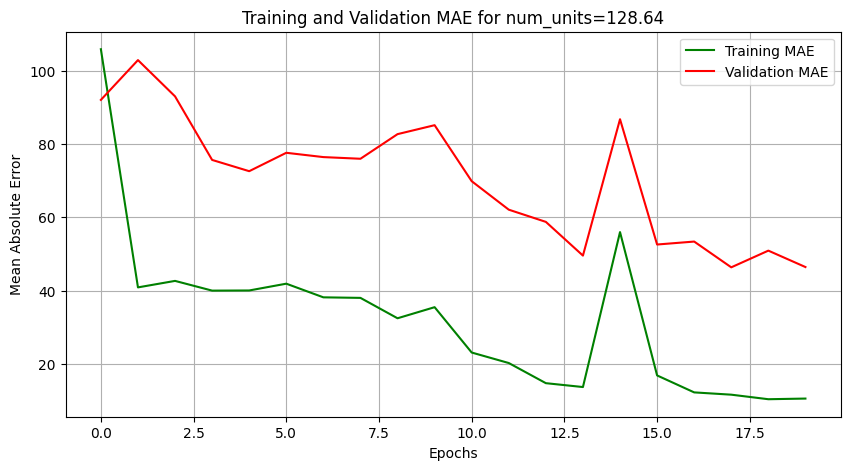

In [ ]:
import matplotlib.pyplot as plt

# List of histories and corresponding number of LSTM units
histories = [history_layer_4, history_unit_128, history_unit_64,history_unit_mix]
num_units = [32, 128, 64, 128.64]  # Update to match your actual models

for history, n in zip(histories, num_units):
    # Plot: Loss (Train + Val)
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title(f'Training and Validation Loss for num_layers={n}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Check if MAE was tracked — only possible if you specified metrics=['mae'] during compile
    if 'mae' in history.history:
        plt.figure(figsize=(10, 5))
        plt.plot(history.history['mae'], label='Training MAE', color='green')
        plt.plot(history.history['val_mae'], label='Validation MAE', color='red')
        plt.title(f'Training and Validation MAE for num_units={n}')
        plt.xlabel('Epochs')
        plt.ylabel('Mean Absolute Error')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print(f"⚠️ MAE metric not available for num_units={n}. Add `metrics=['mae']` in model.compile() if needed.")

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test).flatten()

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / np.maximum(y_test, 1e-10))) * 100

    print(f"📊 {name} Metrics:")
    print(f" - R²:   {r2:.4f}")
    print(f" - RMSE: {rmse:.4f}")
    print(f" - MAE:  {mae:.4f}")
    print(f" - MAPE: {mape:.2f}%\n")

# Evaluate all three models
evaluate_model(model_layer_4, X_test_cnn, y_test, name="LSTM Model (32units)")
evaluate_model(model_unit_128, X_test_cnn, y_test, name="LSTM Model (128 units)")
evaluate_model(model_unit_64, X_test_cnn, y_test, name="LSTM Model (64 units)")
evaluate_model(model_unit_mix, X_test_cnn, y_test, name="LSTM Model (128,64,32,16 units )")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
📊 LSTM Model (32units) Metrics:
 - R²:   0.7081
 - RMSE: 58.2923
 - MAE:  44.9973
 - MAPE: 31.23%

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step
📊 LSTM Model (128 units) Metrics:
 - R²:   0.7273
 - RMSE: 56.3436
 - MAE:  43.5612
 - MAPE: 30.57%

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 244ms/step
📊 LSTM Model (64 units) Metrics:
 - R²:   0.6211
 - RMSE: 66.4123
 - MAE:  49.0828
 - MAPE: 35.98%

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 203ms/step
📊 LSTM Model (128,64,32,16 units ) Metrics:
 - R²:   0.6966
 - RMSE: 59.4333
 - MAE:  46.1676
 - MAPE: 32.10%



**Activation function**

linear ->

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Define the model with 4 LSTM layers
model_act_lin = Sequential()
model_act_lin.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])))
model_act_lin.add(LSTM(128, activation='relu', return_sequences=True))  # Second LSTM layer
model_act_lin.add(LSTM(128, activation='relu', return_sequences=True))  # third LSTM layer
model_act_lin.add(LSTM(128, activation='relu'))  # fourth LSTM layer (no return_sequences)
model_act_lin.add(Dense(1,activation="linear"))  # Output layer

# Compile the model
optimizer_act_lin = Adam(learning_rate=0.01)
model_act_lin.compile(optimizer=optimizer_act_lin, loss='mse',metrics=['mae'])

# Train the model
history_act_lin = model_act_lin.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=20,
    batch_size=16,
    verbose=1
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


87/87 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - loss: 149030.0625 - mae: 314.6388 - val_loss: 15684.3955 - val_mae: 101.8408
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4318.9204 - mae: 52.1169 - val_loss: 14584.3887 - val_mae: 96.3310
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3004.6272 - mae: 41.0879 - val_loss: 15061.0938 - val_mae: 99.8229
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3129.9099 - mae: 42.9295 - val_loss: 10377.2686 - val_mae: 85.4064
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2767.7192 - mae: 40.2307 - val_loss: 12379.1963 - val_mae: 87.7100
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2819.7439 - mae: 39.4581 - val_loss: 10671.4404 - val_mae: 81.7734
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2462.1050 - mae: 35.9007 - val_loss: 13282.4629 - val_mae: 91.6500
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2283.1841 - mae: 34.5747 - val_loss: 15875.9775 - val_mae: 104.4928
Epoc

tanh->

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Define the model with 4 LSTM layers
model_act_tan = Sequential()
model_act_tan.add(LSTM(128, activation='tanh', return_sequences=True, input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])))
model_act_tan.add(LSTM(128, activation='tanh', return_sequences=True))  # Second LSTM layer
model_act_tan.add(LSTM(128, activation='tanh', return_sequences=True))  # third LSTM layer
model_act_tan.add(LSTM(128, activation='tanh'))  # fourth LSTM layer (no return_sequences)
model_act_tan.add(Dense(1,activation="linear"))  # Output layer

# Compile the model
optimizer_act_tan = Adam(learning_rate=0.01)
model_act_tan.compile(optimizer=optimizer_act_tan, loss='mse',metrics=['mae'])

# Train the model
history_act_tan = model_act_tan.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=20,
    batch_size=16,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 139713.2969 - mae: 362.1645 - val_loss: 31487.6172 - val_mae: 138.2291
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 76733.1641 - mae: 263.2308 - val_loss: 18041.4902 - val_mae: 112.6798
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 38619.3125 - mae: 180.3119 - val_loss: 18263.6797 - val_mae: 120.4192
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 20767.9062 - mae: 131.2456 - val_loss: 24353.6289 - val_mae: 133.6008
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 12038.5947 - mae: 98.7106 - val_loss: 31210.8398 - val_mae: 149.3426
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9084.5889 - mae: 83.2569 - val_loss: 36721.0625 - val_mae: 161.8501
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8035.1235 - mae: 75.6230 - val_loss: 40044.0352 - val_mae: 169.3748
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7850.5542 - mae: 72.5244 - val_loss: 41919.5312 

leakyRelu with linear ->



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam

# Define the model with 4 LSTM layers
model_act_leakyrelu = Sequential()
model_act_leakyrelu.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])))
model_act_leakyrelu.add(LSTM(128, activation='relu', return_sequences=True))  # Second LSTM layer
model_act_leakyrelu.add(LSTM(128, activation='relu', return_sequences=True))  # Third LSTM layer
model_act_leakyrelu.add(LSTM(128, activation='relu'))  # Fourth LSTM layer (no return_sequences)

# Dense layer without activation initially
model_act_leakyrelu.add(Dense(32))
# Apply LeakyReLU activation
model_act_leakyrelu.add(LeakyReLU(alpha=0.01))

# Output layer with Linear activation for regression
model_act_leakyrelu.add(Dense(1, activation="linear"))  # Output layer

# Compile the model
optimizer_act_leakyrelu = Adam(learning_rate=0.01)
model_act_leakyrelu.compile(optimizer=optimizer_act_leakyrelu, loss='mse', metrics=['mae'])

# Train the model
history_act_leakyrelu = model_act_leakyrelu.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=20,
    batch_size=16,
    verbose=1
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


87/87 ━━━━━━━━━━━━━━━━━━━━ 14s 66ms/step - loss: 211461.3750 - mae: 349.3201 - val_loss: 25563.0000 - val_mae: 130.4805
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3214.8003 - mae: 39.9225 - val_loss: 16712.1621 - val_mae: 104.3043
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2964.8662 - mae: 40.9935 - val_loss: 14614.3271 - val_mae: 96.5454
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2890.7888 - mae: 39.9913 - val_loss: 19403.6133 - val_mae: 120.1452
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4110.6108 - mae: 51.4814 - val_loss: 11594.5371 - val_mae: 85.8710
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2778.1753 - mae: 39.7023 - val_loss: 13524.0264 - val_mae: 91.9228
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2877.3174 - mae: 39.8346 - val_loss: 7945.0972 - val_mae: 77.0151
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3584.7910 - mae: 47.1616 - val_loss: 7578.7734 - val_mae: 75.1724
Epoch

leakyrelu with no linear ->

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam

# Define the model with 4 LSTM layers
model_act_leakyrelu2 = Sequential()
model_act_leakyrelu2.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])))
model_act_leakyrelu2.add(LSTM(128, activation='relu', return_sequences=True))  # Second LSTM layer
model_act_leakyrelu2.add(LSTM(128, activation='relu', return_sequences=True))  # Third LSTM layer
model_act_leakyrelu2.add(LSTM(128, activation='relu'))  # Fourth LSTM layer (no return_sequences)

# Dense layer without activation initially
model_act_leakyrelu2.add(Dense(32))
# Apply LeakyReLU activation
model_act_leakyrelu2.add(LeakyReLU(alpha=0.01))

model_act_leakyrelu2.add(Dense(1))  # Output layer

# Compile the model
optimizer_act_leakyrelu2 = Adam(learning_rate=0.01)
model_act_leakyrelu2.compile(optimizer=optimizer_act_leakyrelu2, loss='mse', metrics=['mae'])

# Train the model
history_act_leakyrelu2 = model_act_leakyrelu2.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=20,
    batch_size=16,
    verbose=1
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


87/87 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - loss: 149630.7812 - mae: 351.6632 - val_loss: 31333.5938 - val_mae: 147.8119
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5129.2773 - mae: 54.0785 - val_loss: 19801.6426 - val_mae: 114.5299
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3108.8892 - mae: 41.5146 - val_loss: 15991.1875 - val_mae: 101.0885
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3353.8994 - mae: 43.8680 - val_loss: 11150.7119 - val_mae: 85.8262
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3085.2046 - mae: 40.5725 - val_loss: 12878.1143 - val_mae: 89.4927
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2705.4199 - mae: 37.3368 - val_loss: 10642.2705 - val_mae: 80.9813
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2774.2915 - mae: 39.9032 - val_loss: 10069.8008 - val_mae: 79.1899
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2955.9038 - mae: 39.8981 - val_loss: 13894.9404 - val_mae: 98.4032
Epo

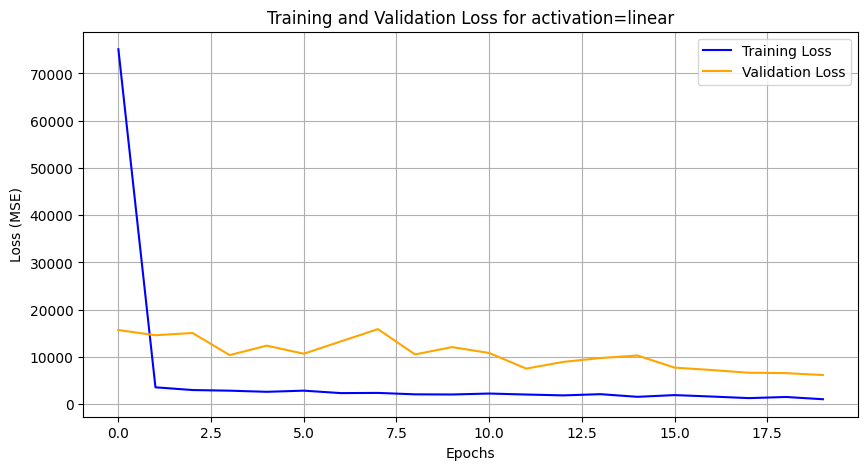

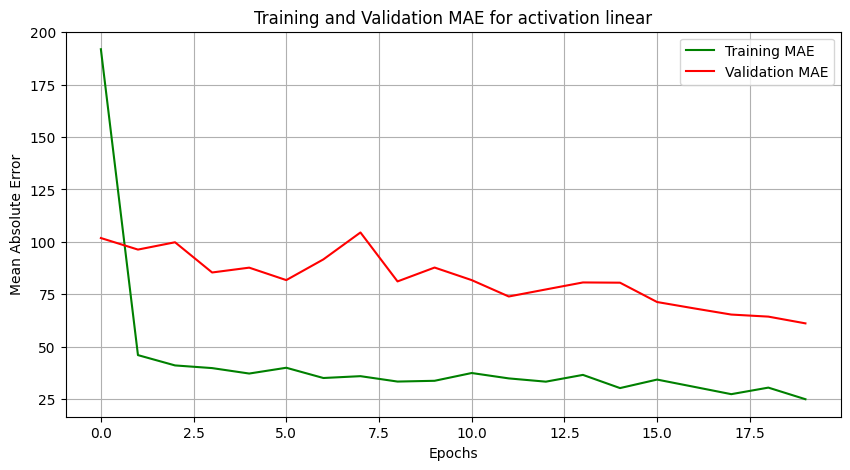

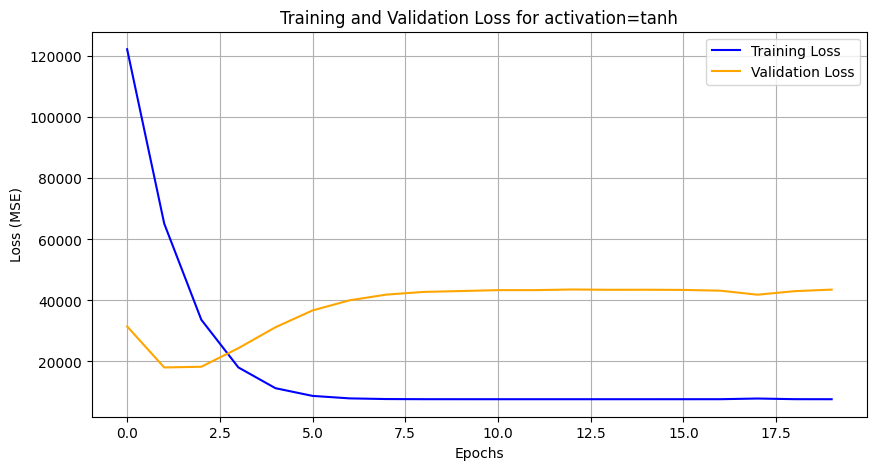

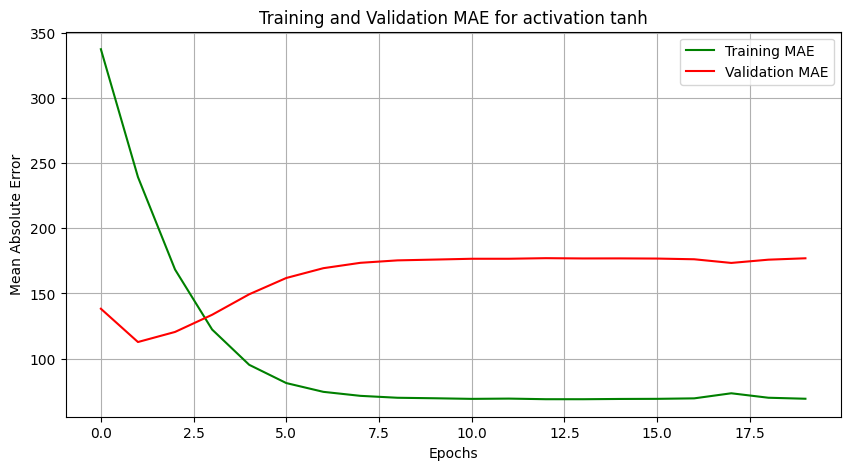

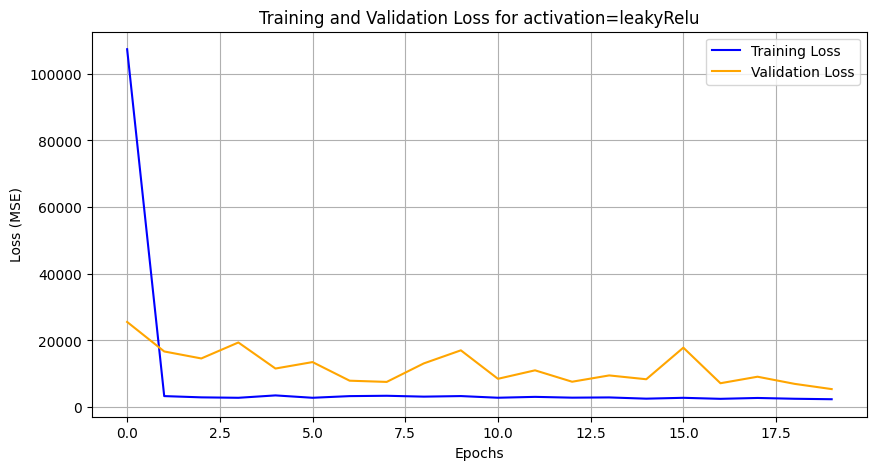

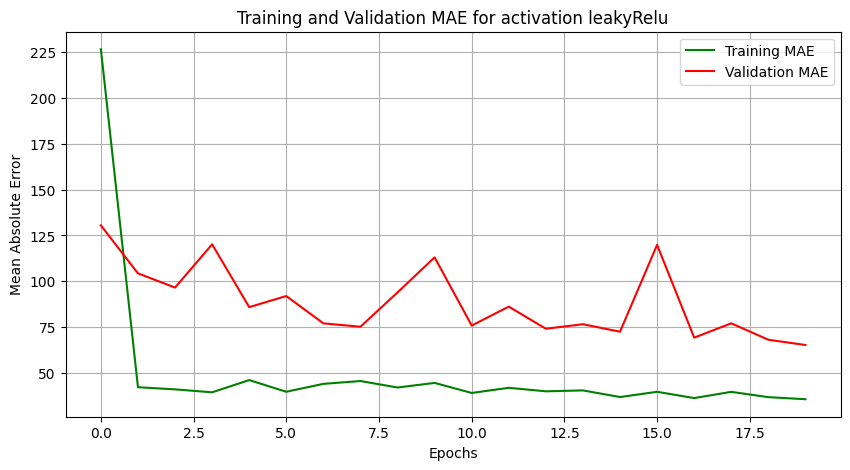

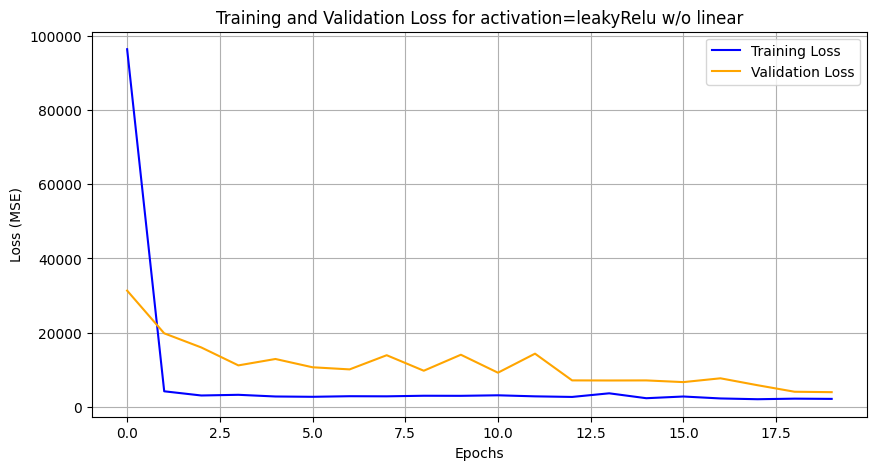

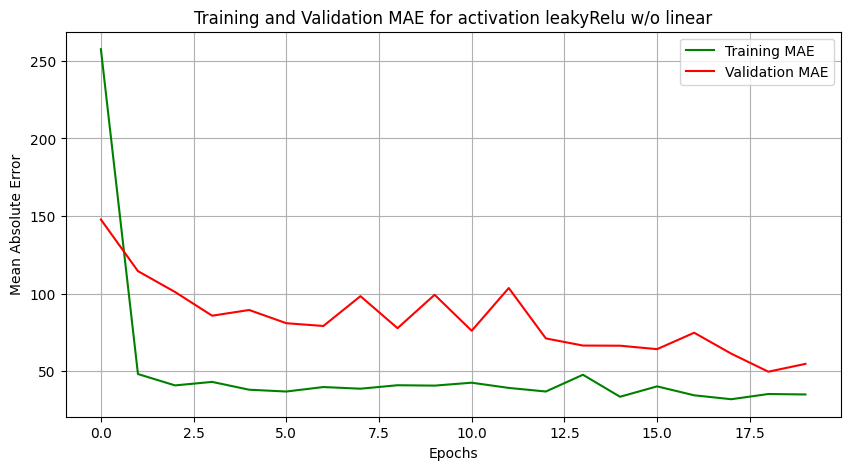

In [ ]:
import matplotlib.pyplot as plt

# List of histories and corresponding number of LSTM units
histories = [history_act_lin, history_act_tan,history_act_leakyrelu,history_act_leakyrelu2]
activations = ["linear","tanh","leakyRelu","leakyRelu w/o linear"]  # Update to match your actual models

for history, n in zip(histories, activations):
    # Plot: Loss (Train + Val)
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title(f'Training and Validation Loss for activation={n}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Check if MAE was tracked — only possible if you specified metrics=['mae'] during compile
    if 'mae' in history.history:
        plt.figure(figsize=(10, 5))
        plt.plot(history.history['mae'], label='Training MAE', color='green')
        plt.plot(history.history['val_mae'], label='Validation MAE', color='red')
        plt.title(f'Training and Validation MAE for activation {n}')
        plt.xlabel('Epochs')
        plt.ylabel('Mean Absolute Error')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print(f"⚠️ MAE metric not available for activations={n}. Add `metrics=['mae']` in model.compile() if needed.")

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test).flatten()

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / np.maximum(y_test, 1e-10))) * 100

    print(f"📊 {name} Metrics:")
    print(f" - R²:   {r2:.4f}")
    print(f" - RMSE: {rmse:.4f}")
    print(f" - MAE:  {mae:.4f}")
    print(f" - MAPE: {mape:.2f}%\n")

# Evaluate all three models
evaluate_model(model_act_lin, X_test_cnn, y_test, name="LSTM Model (linear )")
evaluate_model(model_act_tan, X_test_cnn, y_test, name="LSTM Model (tanh)")
evaluate_model(model_act_leakyrelu, X_test_cnn, y_test, name="LSTM Model (leakyRelu)")
evaluate_model(model_act_leakyrelu2, X_test_cnn, y_test, name="LSTM Model (leakyRelu w/o linear)")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
📊 LSTM Model (linear ) Metrics:
 - R²:   0.4715
 - RMSE: 78.4327
 - MAE:  59.2209
 - MAPE: 43.48%

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
📊 LSTM Model (tanh) Metrics:
 - R²:   -2.5453
 - RMSE: 203.1485
 - MAE:  178.7000
 - MAPE: 121.56%

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
📊 LSTM Model (leakyRelu) Metrics:
 - R²:   0.6424
 - RMSE: 64.5167
 - MAE:  56.1741
 - MAPE: 32.26%

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step
📊 LSTM Model (leakyRelu w/o linear) Metrics:
 - R²:   0.7321
 - RMSE: 55.8412
 - MAE:  47.7430
 - MAPE: 29.57%



LSTM Model (128 units) Metrics: ( uses only Relu )
 - R²:   0.7273
 - RMSE: 56.3436
 - MAE:  43.5612
 - MAPE: 30.57%


choosing leakyRelu w/o linear activation

**optimizers**

* adam has already been tested in the prev model

SGD->

In [ ]:
import numpy as np

# Check for NaN or infinite values
print(np.isnan(X_train_cnn).any(), np.isnan(y_train).any())
print(np.isinf(X_train_cnn).any(), np.isinf(y_train).any())

False False
False False


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, LeakyReLU
from tensorflow.keras.optimizers import SGD

# Define the model
model_sgd = Sequential()
model_sgd.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])))
model_sgd.add(LSTM(128, activation='relu', return_sequences=True))  # Second LSTM layer
model_sgd.add(LSTM(128, activation='relu', return_sequences=True))  # Third LSTM layer
model_sgd.add(LSTM(128, activation='relu'))  # Fourth LSTM layer (no return_sequences)

# Dense layer without activation initially
model_sgd.add(Dense(32))
model_sgd.add(LeakyReLU(alpha=0.01))  # Apply LeakyReLU activation

# Output layer for regression
model_sgd.add(Dense(1))

# Compile the model with SGD optimizer
optimizer_sgd = SGD(learning_rate=0.001, momentum=0.9, nesterov=True,clipvalue=1.0)  # Momentum and Nesterov added
model_sgd.compile(optimizer=optimizer_sgd, loss='mse', metrics=['mae'])

# Train the model
history_sgd = model_sgd.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=20,
    batch_size=16,
    verbose=1
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 297263.2500 - mae: 390.4419 - val_loss: 5392.9258 - val_mae: 62.9426
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 68692.5000 - mae: 192.1928 - val_loss: 13936.1553 - val_mae: 93.8926
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 40015.7773 - mae: 154.4172 - val_loss: 11123.6777 - val_mae: 89.5512
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 22148.9746 - mae: 124.0402 - val_loss: 8049.6865 - val_mae: 80.4942
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 19927.1211 - mae: 118.0042 - val_loss: 6117.7295 - val_mae: 68.6285
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 11433.6094 - mae: 89.9684 - val_loss: 27537.3379 - val_mae: 157.2910
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10880.7520 - mae: 88.3186 - val_loss: 6064.9028 - val_mae: 68.9445
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9718.6631 - mae: 84.3710 - val_loss: 23203.8105 - val_mae: 143.407

RMS Prop ->

In [ ]:
from tensorflow.keras.optimizers import RMSprop

# Define the model
model_rmsprop = Sequential()
model_rmsprop.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])))
model_rmsprop.add(LSTM(128, activation='relu', return_sequences=True))  # Second LSTM layer
model_rmsprop.add(LSTM(128, activation='relu', return_sequences=True))  # Third LSTM layer
model_rmsprop.add(LSTM(128, activation='relu'))  # Fourth LSTM layer (no return_sequences)

# Dense layer without activation initially
model_rmsprop.add(Dense(32))
model_rmsprop.add(LeakyReLU(alpha=0.01))  # Apply LeakyReLU activation

# Output layer for regression
model_rmsprop.add(Dense(1))

# Compile the model with RMSProp optimizer
optimizer_rmsprop = RMSprop(learning_rate=0.001, rho=0.9)  # Rho for moving averages
model_rmsprop.compile(optimizer=optimizer_rmsprop, loss='mse', metrics=['mae'])

# Train the model
history_rmsprop = model_rmsprop.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=20,
    batch_size=16,
    verbose=1
)


Epoch 1/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - loss: 69349.8047 - mae: 204.0601 - val_loss: 8394.6221 - val_mae: 75.9750
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 8152.9937 - mae: 68.3350 - val_loss: 7999.0820 - val_mae: 79.5835
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7888.7812 - mae: 73.1803 - val_loss: 25004.3242 - val_mae: 142.1821
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7955.6904 - mae: 72.9768 - val_loss: 9438.4746 - val_mae: 84.5363
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6631.2969 - mae: 64.9046 - val_loss: 61300.1758 - val_mae: 240.4368
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8340.0312 - mae: 68.8656 - val_loss: 10857.5928 - val_mae: 87.1109
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6875.8599 - mae: 67.7969 - val_loss: 20357.5098 - val_mae: 124.6755
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6078.4897 - mae: 65.4442 - val_loss: 8304.1240 - val_mae: 81.67

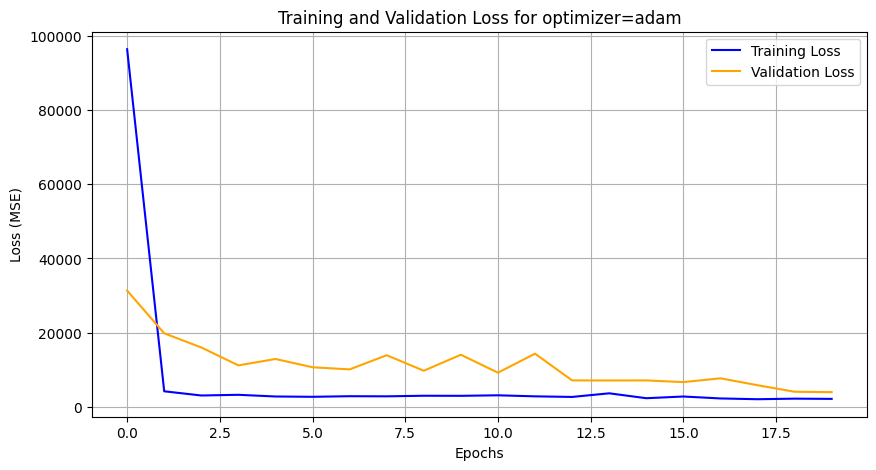

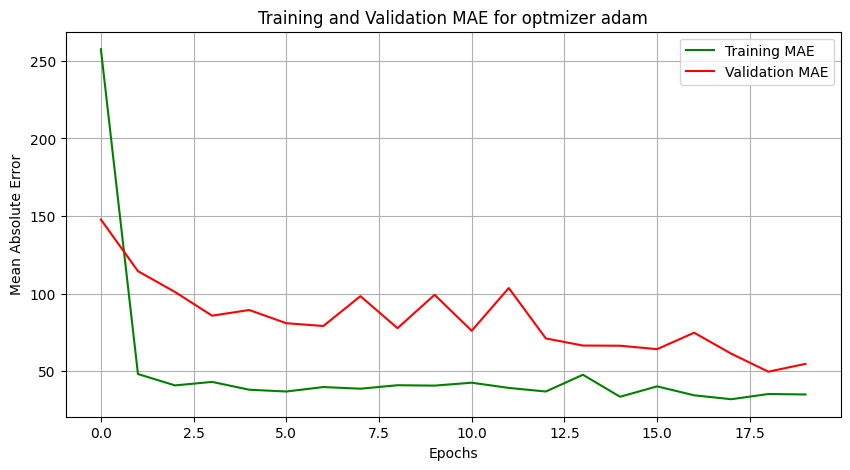

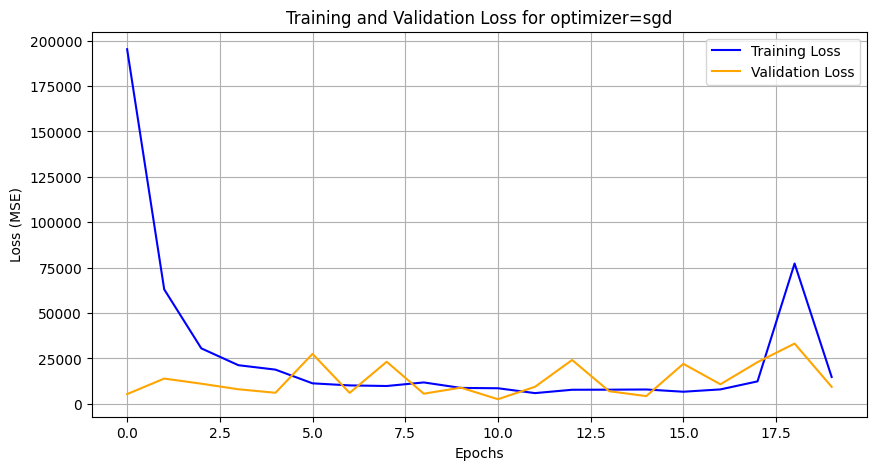

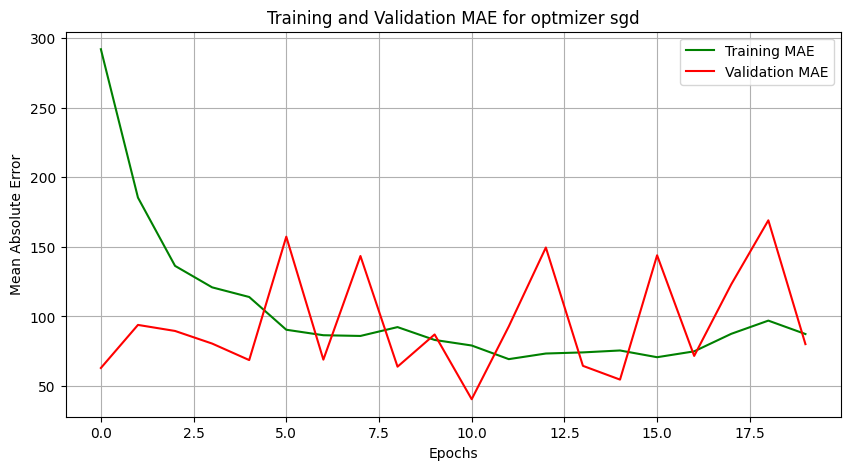

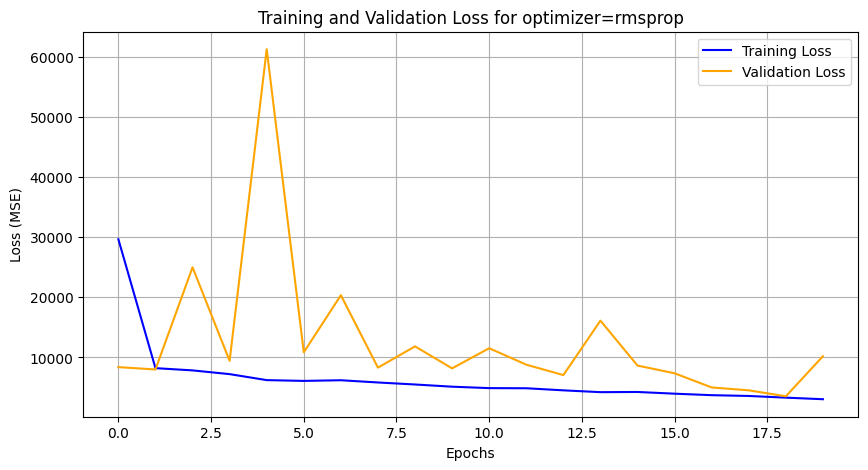

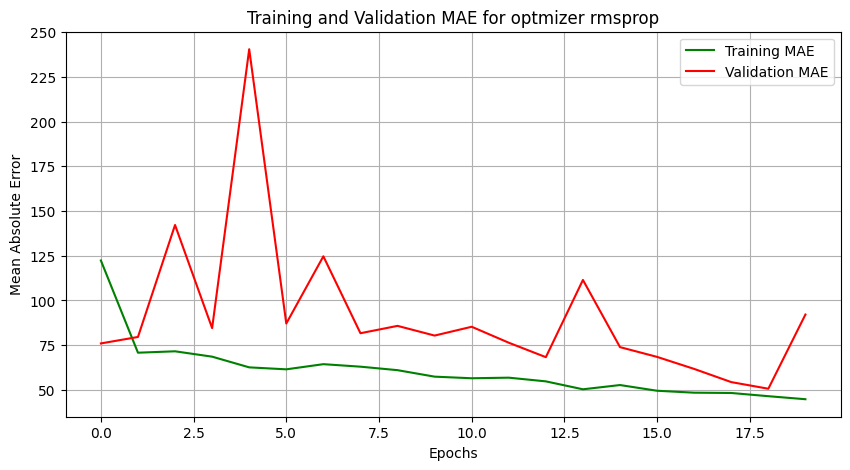

In [ ]:
import matplotlib.pyplot as plt

# List of histories and corresponding number of LSTM units
histories = [history_act_leakyrelu2,history_sgd,history_rmsprop]
optimizers = ["adam","sgd","rmsprop"]  # Update to match your actual models

for history, n in zip(histories, optimizers):
    # Plot: Loss (Train + Val)
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title(f'Training and Validation Loss for optimizer={n}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Check if MAE was tracked — only possible if you specified metrics=['mae'] during compile
    if 'mae' in history.history:
        plt.figure(figsize=(10, 5))
        plt.plot(history.history['mae'], label='Training MAE', color='green')
        plt.plot(history.history['val_mae'], label='Validation MAE', color='red')
        plt.title(f'Training and Validation MAE for optmizer {n}')
        plt.xlabel('Epochs')
        plt.ylabel('Mean Absolute Error')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print(f"⚠️ MAE metric not available for optimizers={n}. Add `metrics=['mae']` in model.compile() if needed.")

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test).flatten()

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / np.maximum(y_test, 1e-10))) * 100

    print(f"📊 {name} Metrics:")
    print(f" - R²:   {r2:.4f}")
    print(f" - RMSE: {rmse:.4f}")
    print(f" - MAE:  {mae:.4f}")
    print(f" - MAPE: {mape:.2f}%\n")

# Evaluate all three models
evaluate_model(model_act_leakyrelu2, X_test_cnn, y_test, name="LSTM Model (adam)")
evaluate_model(model_sgd, X_test_cnn, y_test, name="LSTM Model (Sdg)")
evaluate_model(model_rmsprop, X_test_cnn, y_test, name="LSTM Model (rmsprop)")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
📊 LSTM Model (adam) Metrics:
 - R²:   0.7321
 - RMSE: 55.8412
 - MAE:  47.7430
 - MAPE: 29.57%

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step
📊 LSTM Model (Sdg) Metrics:
 - R²:   0.2652
 - RMSE: 92.4841
 - MAE:  74.6963
 - MAPE: 53.53%

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step
📊 LSTM Model (rmsprop) Metrics:
 - R²:   0.1829
 - RMSE: 97.5247
 - MAE:  85.0770
 - MAPE: 55.15%



adam works best

**Learning rate**

previous model already uses 0.01

0.001 ->

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam

# Define the model with 4 LSTM layers
model_adam = Sequential()
model_adam.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])))
model_adam.add(LSTM(128, activation='relu', return_sequences=True))  # Second LSTM layer
model_adam.add(LSTM(128, activation='relu', return_sequences=True))  # Third LSTM layer
model_adam.add(LSTM(128, activation='relu'))  # Fourth LSTM layer (no return_sequences)

# Dense layer without activation initially
model_adam.add(Dense(32))
# Apply LeakyReLU activation
model_adam.add(LeakyReLU(alpha=0.01))

model_adam.add(Dense(1))  # Output layer

# Compile the model
optimizer_adam = Adam(learning_rate=0.001)
model_adam.compile(optimizer=optimizer_adam, loss='mse', metrics=['mae'])

# Train the model
history_adam = model_adam.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=20,
    batch_size=16,
    verbose=1
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


87/87 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step - loss: 121607.0781 - mae: 311.9995 - val_loss: 6801.0737 - val_mae: 69.3094
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3509.6841 - mae: 46.7199 - val_loss: 8718.4502 - val_mae: 78.8071
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3113.5935 - mae: 43.2282 - val_loss: 10820.2041 - val_mae: 84.1427
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2713.7358 - mae: 38.8919 - val_loss: 11192.5840 - val_mae: 84.3212
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2803.4812 - mae: 39.9358 - val_loss: 14278.7461 - val_mae: 95.6131
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2564.6021 - mae: 36.8491 - val_loss: 12490.8760 - val_mae: 87.6396
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2443.7607 - mae: 35.9598 - val_loss: 10875.9326 - val_mae: 82.9855
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2574.9053 - mae: 36.9338 - val_loss: 15423.4873 - val_mae: 101.9207
Epoch 9

0.0001->

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam

# Define the model with 4 LSTM layers
model_adam1 = Sequential()
model_adam1.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])))
model_adam1.add(LSTM(128, activation='relu', return_sequences=True))  # Second LSTM layer
model_adam1.add(LSTM(128, activation='relu', return_sequences=True))  # Third LSTM layer
model_adam1.add(LSTM(128, activation='relu'))  # Fourth LSTM layer (no return_sequences)

# Dense layer without activation initially
model_adam1.add(Dense(32))
# Apply LeakyReLU activation
model_adam1.add(LeakyReLU(alpha=0.01))

model_adam1.add(Dense(1))  # Output layer

# Compile the model
optimizer_adam1 = Adam(learning_rate=0.0001)
model_adam1.compile(optimizer=optimizer_adam1, loss='mse', metrics=['mae'])

# Train the model
history_adam1 = model_adam1.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=20,
    batch_size=16,
    verbose=1
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


87/87 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - loss: 169589.6719 - mae: 402.1843 - val_loss: 73599.0234 - val_mae: 237.9601
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 150515.2969 - mae: 369.5942 - val_loss: 5140.3384 - val_mae: 56.2413
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7400.9663 - mae: 69.2326 - val_loss: 4011.1592 - val_mae: 54.1235
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5478.1953 - mae: 59.5548 - val_loss: 5352.5059 - val_mae: 62.8645
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4106.7222 - mae: 51.9359 - val_loss: 5763.8926 - val_mae: 65.9935
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3623.9158 - mae: 48.2285 - val_loss: 8256.7998 - val_mae: 75.3250
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3225.7856 - mae: 45.2003 - val_loss: 9429.8281 - val_mae: 79.4800
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2911.1531 - mae: 42.3722 - val_loss: 9308.8525 - val_mae: 79.5928
Epoch 9/2

0.0005->

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam

# Define the model with 4 LSTM layers
model_adam2 = Sequential()
model_adam2.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])))
model_adam2.add(LSTM(128, activation='relu', return_sequences=True))  # Second LSTM layer
model_adam2.add(LSTM(128, activation='relu', return_sequences=True))  # Third LSTM layer
model_adam2.add(LSTM(128, activation='relu'))  # Fourth LSTM layer (no return_sequences)

# Dense layer without activation initially
model_adam2.add(Dense(32))
# Apply LeakyReLU activation
model_adam2.add(LeakyReLU(alpha=0.01))

model_adam2.add(Dense(1))  # Output layer

# Compile the model
optimizer_adam2 = Adam(learning_rate=0.0005)
model_adam2.compile(optimizer=optimizer_adam2, loss='mse', metrics=['mae'])

# Train the model
history_adam2 = model_adam2.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=20,
    batch_size=16,
    verbose=1
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


87/87 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - loss: 144886.5781 - mae: 357.7595 - val_loss: 6632.3071 - val_mae: 68.8318
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4098.8267 - mae: 51.2971 - val_loss: 9537.0049 - val_mae: 80.6232
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3080.9553 - mae: 42.6469 - val_loss: 10382.3643 - val_mae: 83.3068
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2819.7922 - mae: 40.4829 - val_loss: 13100.2725 - val_mae: 89.8973
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2709.3232 - mae: 38.4334 - val_loss: 10540.1660 - val_mae: 83.5231
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 2785.9761 - mae: 37.8488 - val_loss: 12580.4082 - val_mae: 87.3586
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2612.2739 - mae: 35.8605 - val_loss: 12462.6553 - val_mae: 86.9417
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2578.5703 - mae: 36.6078 - val_loss: 13928.1426 - val_mae: 93.2155
Epoc

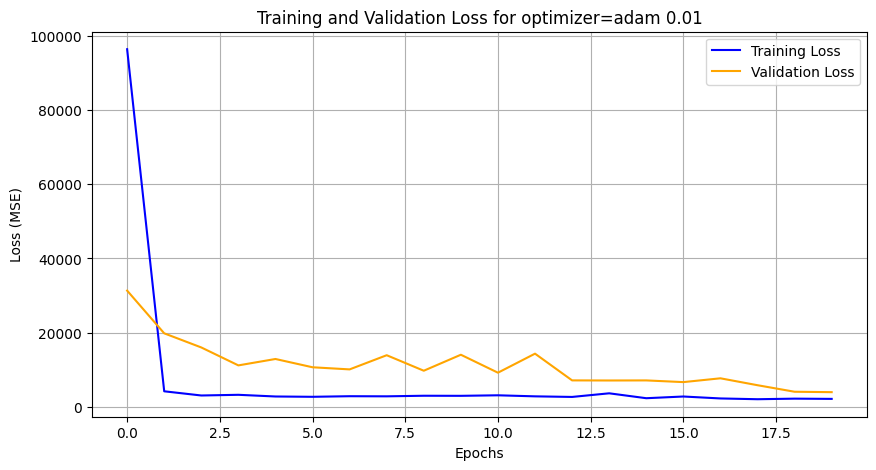

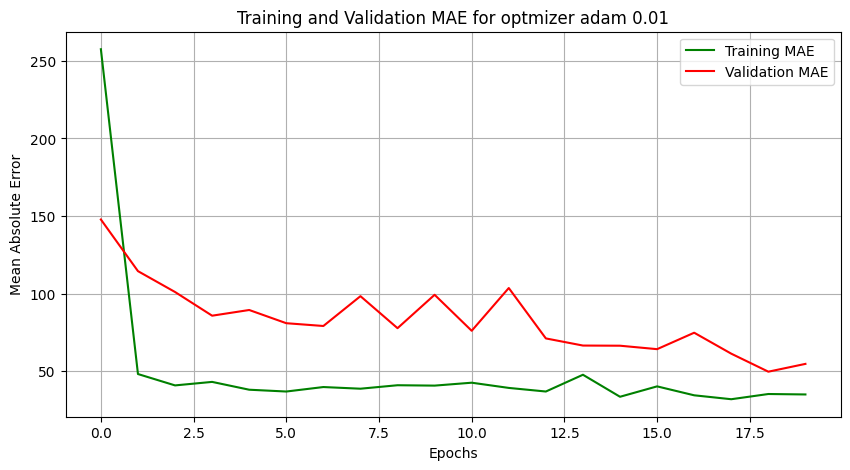

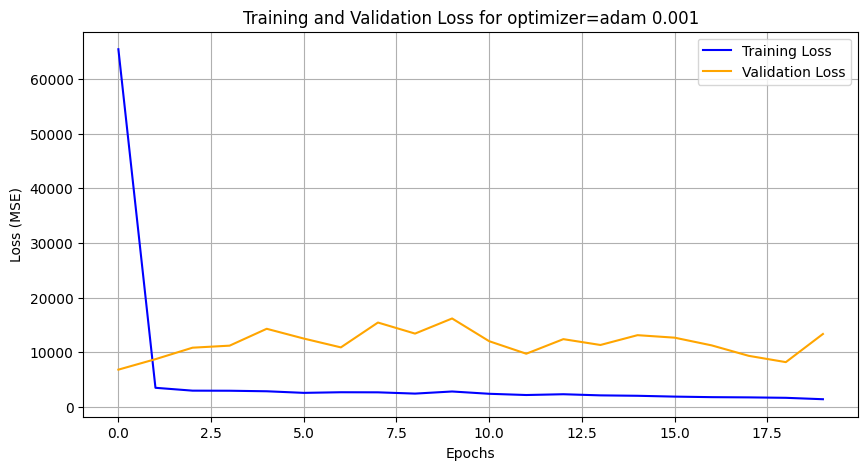

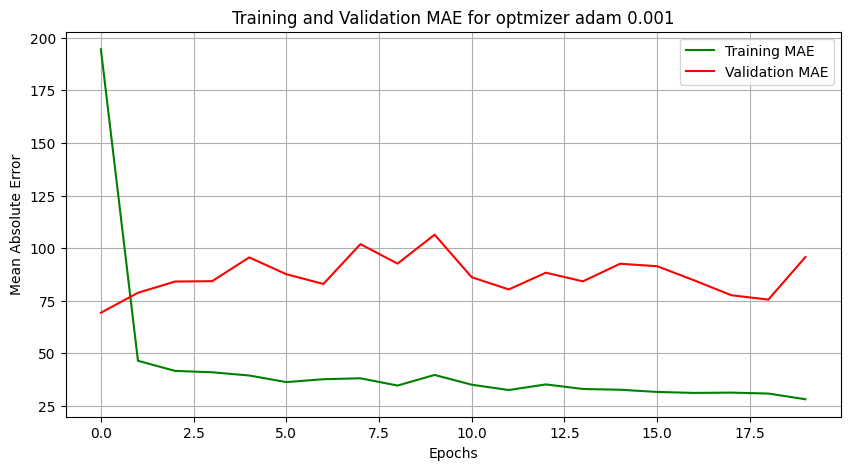

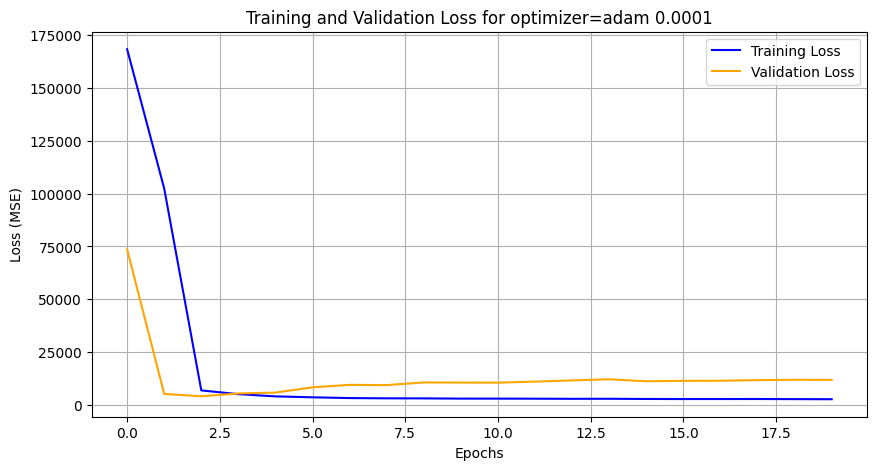

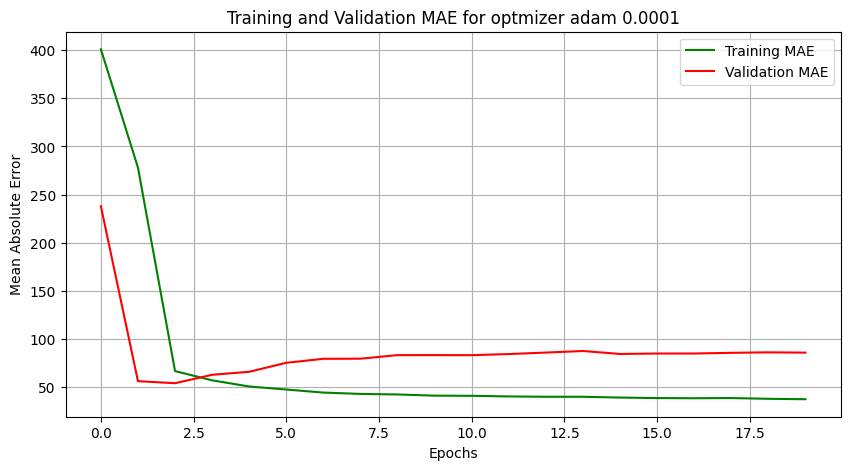

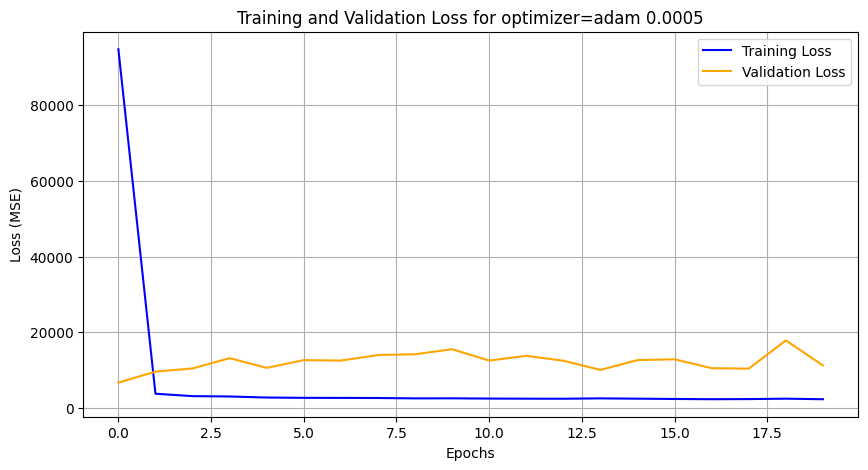

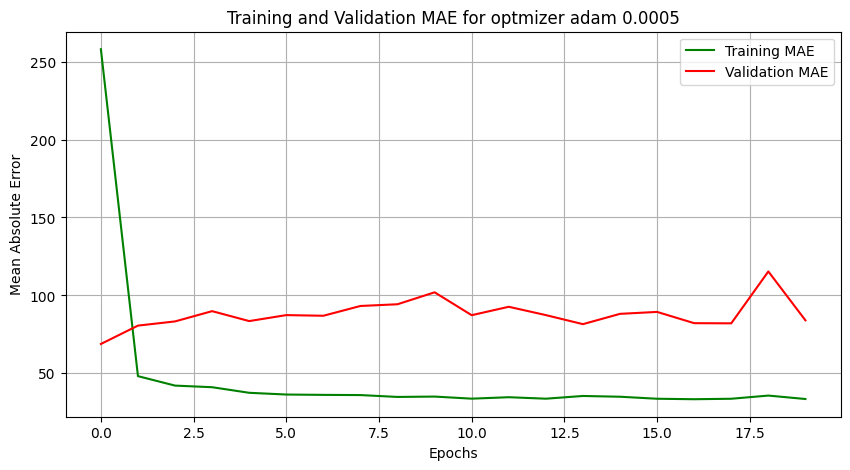

In [ ]:
import matplotlib.pyplot as plt

# List of histories and corresponding number of LSTM units
histories = [history_act_leakyrelu2,history_adam,history_adam1,history_adam2]
optimizers = ["adam 0.01","adam 0.001","adam 0.0001","adam 0.0005"]  # Update to match your actual models

for history, n in zip(histories, optimizers):
    # Plot: Loss (Train + Val)
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title(f'Training and Validation Loss for optimizer={n}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Check if MAE was tracked — only possible if you specified metrics=['mae'] during compile
    if 'mae' in history.history:
        plt.figure(figsize=(10, 5))
        plt.plot(history.history['mae'], label='Training MAE', color='green')
        plt.plot(history.history['val_mae'], label='Validation MAE', color='red')
        plt.title(f'Training and Validation MAE for optmizer {n}')
        plt.xlabel('Epochs')
        plt.ylabel('Mean Absolute Error')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print(f"⚠️ MAE metric not available for optimizers={n}. Add `metrics=['mae']` in model.compile() if needed.")

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test).flatten()

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / np.maximum(y_test, 1e-10))) * 100

    print(f"📊 {name} Metrics:")
    print(f" - R²:   {r2:.4f}")
    print(f" - RMSE: {rmse:.4f}")
    print(f" - MAE:  {mae:.4f}")
    print(f" - MAPE: {mape:.2f}%\n")

# Evaluate all three models
evaluate_model(model_act_leakyrelu2, X_test_cnn, y_test, name="LSTM Model (adam 0.01)")
evaluate_model(model_adam, X_test_cnn, y_test, name="LSTM Model (adam 0.001)")
evaluate_model(model_adam1, X_test_cnn, y_test, name="LSTM Model (adam 0.0001)")
evaluate_model(model_adam2, X_test_cnn, y_test, name="LSTM Model (adam 0.0005)")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
📊 LSTM Model (adam 0.01) Metrics:
 - R²:   0.7321
 - RMSE: 55.8412
 - MAE:  47.7430
 - MAPE: 29.57%

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step
📊 LSTM Model (adam 0.001) Metrics:
 - R²:   -0.1645
 - RMSE: 116.4298
 - MAE:  94.9849
 - MAPE: 66.81%

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step
📊 LSTM Model (adam 0.0001) Metrics:
 - R²:   0.0256
 - RMSE: 106.5021
 - MAE:  83.2921
 - MAPE: 61.13%



7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step
📊 LSTM Model (adam 0.0005) Metrics:
 - R²:   0.0791
 - RMSE: 103.5392
 - MAE:  81.1095
 - MAPE: 59.33%



0.01 works best <-

**Loss Function**

- 'mse' ( used before )
- 'mae'
- 'huber'
- 'logcosh'

MAE ->

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam

# Define the model with 4 LSTM layers
model_loss = Sequential()
model_loss.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])))
model_loss.add(LSTM(128, activation='relu', return_sequences=True))  # Second LSTM layer
model_loss.add(LSTM(128, activation='relu', return_sequences=True))  # Third LSTM layer
model_loss.add(LSTM(128, activation='relu'))  # Fourth LSTM layer (no return_sequences)

# Dense layer without activation initially
model_loss.add(Dense(32))
# Apply LeakyReLU activation
model_loss.add(LeakyReLU(alpha=0.01))

model_loss.add(Dense(1))  # Output layer

# Compile the model
optimizer_loss = Adam(learning_rate=0.01)
model_loss.compile(optimizer=optimizer_loss, loss='mae', metrics=['mae'])

# Train the model
history_loss = model_loss.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=20,
    batch_size=16,
    verbose=1
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


87/87 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - loss: 182.2729 - mae: 182.2729 - val_loss: 106.5407 - val_mae: 106.5407
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 59.5648 - mae: 59.5648 - val_loss: 87.8754 - val_mae: 87.8754
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 48.0326 - mae: 48.0326 - val_loss: 63.3003 - val_mae: 63.3003
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 42.3004 - mae: 42.3004 - val_loss: 221.7162 - val_mae: 221.7162
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 76.9793 - mae: 76.9793 - val_loss: 74.9826 - val_mae: 74.9826
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 32.2603 - mae: 32.2603 - val_loss: 73.8559 - val_mae: 73.8559
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 38.2541 - mae: 38.2541 - val_loss: 56.5328 - val_mae: 56.5328
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 49.4415 - mae: 49.4415 - val_loss: 155.5897 - val_mae: 155.5897
Epoch 9/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 

Huber ->

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam

# Define the model with 4 LSTM layers
model_loss1 = Sequential()
model_loss1.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])))
model_loss1.add(LSTM(128, activation='relu', return_sequences=True))  # Second LSTM layer
model_loss1.add(LSTM(128, activation='relu', return_sequences=True))  # Third LSTM layer
model_loss1.add(LSTM(128, activation='relu'))  # Fourth LSTM layer (no return_sequences)

# Dense layer without activation initially
model_loss1.add(Dense(32))
# Apply LeakyReLU activation
model_loss1.add(LeakyReLU(alpha=0.01))

model_loss1.add(Dense(1))  # Output layer

# Compile the model
optimizer_loss1 = Adam(learning_rate=0.01)
model_loss1.compile(optimizer=optimizer_loss1, loss='huber', metrics=['mae'])

# Train the model
history_loss1 = model_loss1.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=20,
    batch_size=16,
    verbose=1
)


Epoch 1/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - loss: 385.1175 - mae: 385.6168 - val_loss: 143.0142 - val_mae: 143.5135
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 65.4652 - mae: 65.9613 - val_loss: 82.9136 - val_mae: 83.4100
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 46.6225 - mae: 47.1205 - val_loss: 164.3517 - val_mae: 164.8517
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 60.6181 - mae: 61.1171 - val_loss: 94.0938 - val_mae: 94.5916
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 38.4747 - mae: 38.9714 - val_loss: 79.3712 - val_mae: 79.8635
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 37.9171 - mae: 38.4138 - val_loss: 99.8639 - val_mae: 100.3639
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 41.0634 - mae: 41.5585 - val_loss: 79.8514 - val_mae: 80.3503
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 61.1119 - mae: 61.6098 - val_loss: 62.7922 - val_mae: 63.2869
Epoch 9/20
87/87 ━━━━━━━━━━━━━━

log_cosh->

In [ ]:
pip install --upgrade tensorflow


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam

# Define the model with 4 LSTM layers
model_loss2 = Sequential()
model_loss2.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])))
model_loss2.add(LSTM(128, activation='relu', return_sequences=True))  # Second LSTM layer
model_loss2.add(LSTM(128, activation='relu', return_sequences=True))  # Third LSTM layer
model_loss2.add(LSTM(128, activation='relu'))  # Fourth LSTM layer (no return_sequences)

# Dense layer without activation initially
model_loss2.add(Dense(32))
model_loss2.add(LeakyReLU(negative_slope=0.01))  # Updated to use `negative_slope`

model_loss2.add(Dense(1))  # Output layer

# Compile the model with logcosh loss
optimizer_loss2 = Adam(learning_rate=0.01)
model_loss2.compile(optimizer=optimizer_loss2, loss=tf.keras.losses.LogCosh(), metrics=['mae'])

# Train the model
history_loss2 = model_loss2.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=20,
    batch_size=16,
    verbose=1
)



Epoch 1/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - loss: 325.5262 - mae: 326.2187 - val_loss: 88.4367 - val_mae: 89.1279
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 47.4502 - mae: 48.1350 - val_loss: 99.2523 - val_mae: 99.9442
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 40.8275 - mae: 41.5110 - val_loss: 60.1424 - val_mae: 60.8329
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 80.2561 - mae: 80.9445 - val_loss: 45.8885 - val_mae: 46.5796
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 37.5295 - mae: 38.2142 - val_loss: 68.6340 - val_mae: 69.3234
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 37.2501 - mae: 37.9370 - val_loss: 42.9483 - val_mae: 43.6332
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 34.1009 - mae: 34.7871 - val_loss: 47.5811 - val_mae: 48.2655
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 37.2838 - mae: 37.9679 - val_loss: 32.6890 - val_mae: 33.3722
Epoch 9/20
87/87 ━━━━━━━━━━━━━━━━━━━

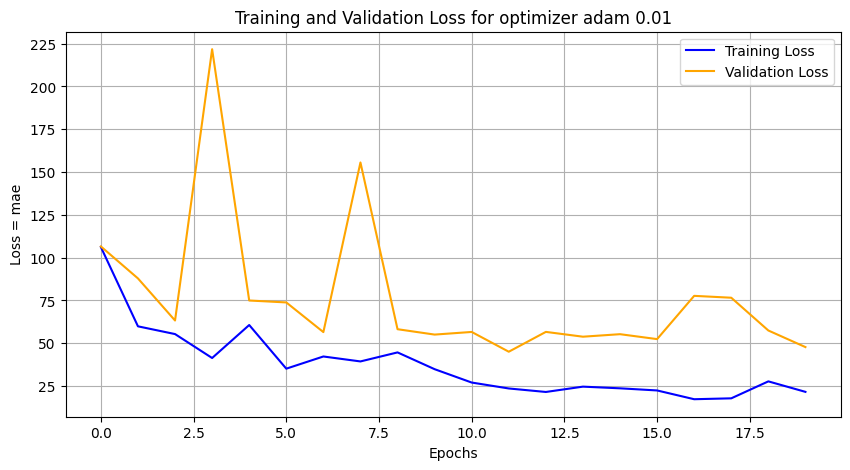

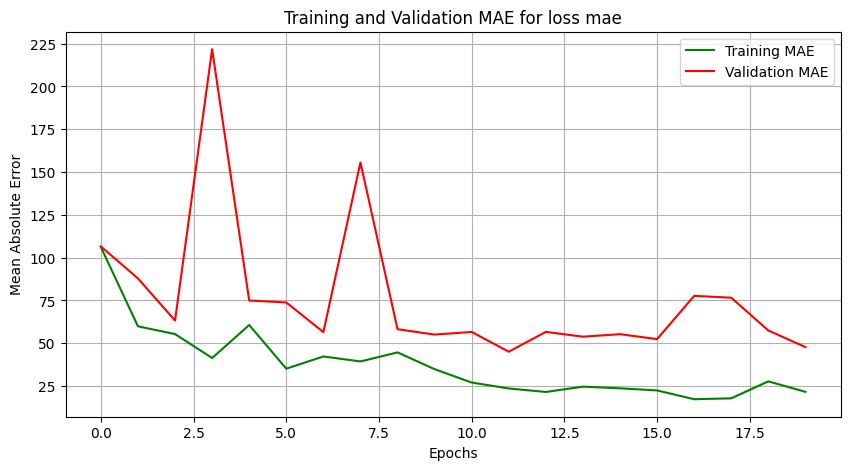

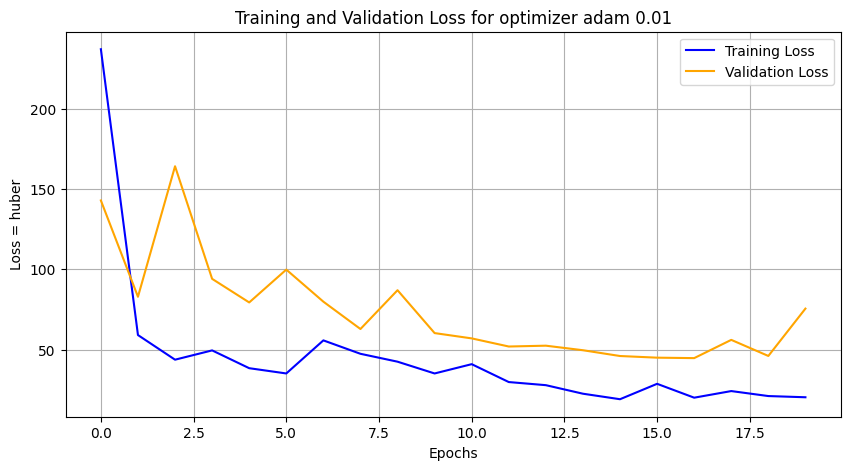

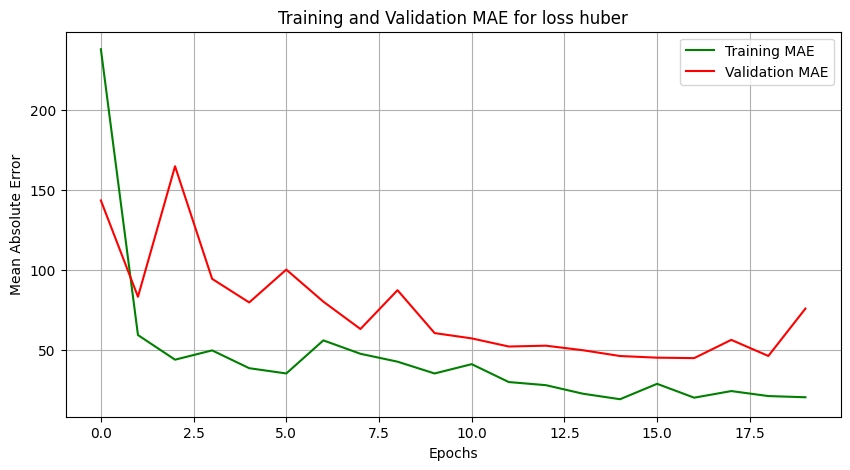

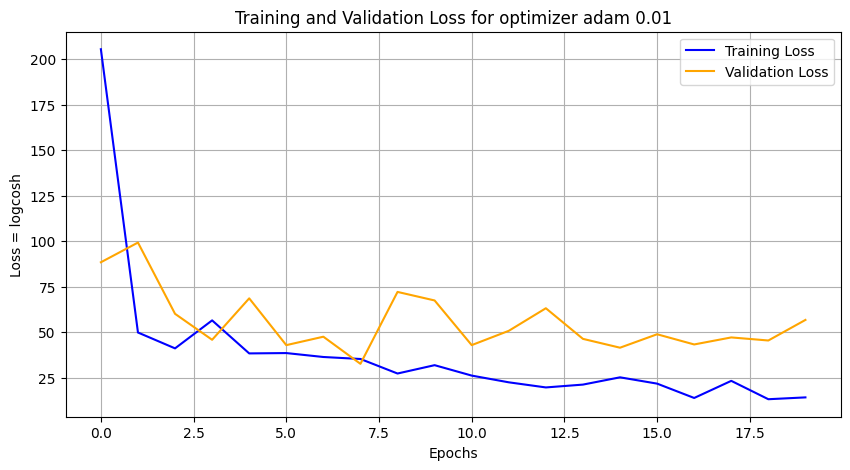

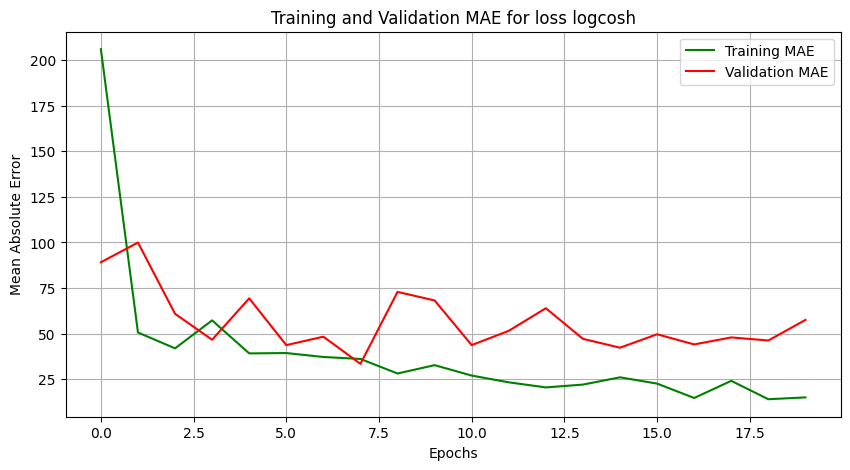

In [ ]:
import matplotlib.pyplot as plt

# List of histories and corresponding number of LSTM units
histories = [history_loss,history_loss1,history_loss2]
loss_funct = ["mae","huber","logcosh"]  # Update to match your actual models

for history, n in zip(histories, loss_funct):
    # Plot: Loss (Train + Val)
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title(f'Training and Validation Loss for optimizer adam 0.01')
    plt.xlabel('Epochs')
    plt.ylabel(f'Loss = {n}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Check if MAE was tracked — only possible if you specified metrics=['mae'] during compile
    if 'mae' in history.history:
        plt.figure(figsize=(10, 5))
        plt.plot(history.history['mae'], label='Training MAE', color='green')
        plt.plot(history.history['val_mae'], label='Validation MAE', color='red')
        plt.title(f'Training and Validation MAE for loss {n}')
        plt.xlabel('Epochs')
        plt.ylabel('Mean Absolute Error')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print(f"⚠️ MAE metric not available for loss_funct ={n}. Add `metrics=['mae']` in model.compile() if needed.")

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test).flatten()

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / np.maximum(y_test, 1e-10))) * 100

    print(f"📊 {name} Metrics:")
    print(f" - R²:   {r2:.4f}")
    print(f" - RMSE: {rmse:.4f}")
    print(f" - MAE:  {mae:.4f}")
    print(f" - MAPE: {mape:.2f}%\n")

# Evaluate all three models
evaluate_model(model_loss, X_test_cnn, y_test, name="LSTM Model (mae)")
evaluate_model(model_loss1, X_test_cnn, y_test, name="LSTM Model (huber)")
evaluate_model(model_loss2, X_test_cnn, y_test, name="LSTM Model (logcosh)")

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 221ms/step
📊 LSTM Model (mae) Metrics:
 - R²:   0.6854
 - RMSE: 60.5160
 - MAE:  44.2992
 - MAPE: 33.42%

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step
📊 LSTM Model (huber) Metrics:
 - R²:   0.4143
 - RMSE: 82.5729
 - MAE:  71.4530
 - MAPE: 47.44%



7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 197ms/step
📊 LSTM Model (logcosh) Metrics:
 - R²:   0.6215
 - RMSE: 66.3769
 - MAE:  53.2689
 - MAPE: 36.50%



LSTM Model (mse) Metrics:
 - R²:   0.7321
 - RMSE: 55.8412
 - MAE:  47.7430
 - MAPE: 29.57%

**MSE is better**

epoch 50

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam

# Define the model with 4 LSTM layers
model_epoch50 = Sequential()
model_epoch50.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])))
model_epoch50.add(LSTM(128, activation='relu', return_sequences=True))  # Second LSTM layer
model_epoch50.add(LSTM(128, activation='relu', return_sequences=True))  # Third LSTM layer
model_epoch50.add(LSTM(128, activation='relu'))  # Fourth LSTM layer (no return_sequences)

# Dense layer without activation initially
model_epoch50.add(Dense(32))
# Apply LeakyReLU activation
model_epoch50.add(LeakyReLU(alpha=0.01))

model_epoch50.add(Dense(1))  # Output layer

# Compile the model
optimizer_epoch50 = Adam(learning_rate=0.01)
model_epoch50.compile(optimizer=optimizer_epoch50, loss='mse', metrics=['mae'])

# Train the model
history_epoch50 = model_epoch50.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=50,
    batch_size=16,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


87/87 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - loss: 136801.2969 - mae: 320.4761 - val_loss: 15004.6025 - val_mae: 98.7127
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3869.0830 - mae: 47.5653 - val_loss: 14439.5381 - val_mae: 95.3580
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3039.5378 - mae: 41.7521 - val_loss: 18113.6934 - val_mae: 113.5713
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3527.7837 - mae: 46.2768 - val_loss: 14810.4443 - val_mae: 96.5756
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2776.8137 - mae: 38.5481 - val_loss: 11348.5918 - val_mae: 87.1058
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2776.7661 - mae: 39.6312 - val_loss: 8798.2764 - val_mae: 76.1957
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3360.1350 - mae: 45.0632 - val_loss: 8075.7778 - val_mae: 75.2167
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2011.0055 - mae: 32.7926 - val_loss: 8683.0449 - val_mae: 74.0423
Epoch 9/

epoch 100->

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam

# Define the model with 4 LSTM layers
model_epoch100 = Sequential()
model_epoch100.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])))
model_epoch100.add(LSTM(128, activation='relu', return_sequences=True))  # Second LSTM layer
model_epoch100.add(LSTM(128, activation='relu', return_sequences=True))  # Third LSTM layer
model_epoch100.add(LSTM(128, activation='relu'))  # Fourth LSTM layer (no return_sequences)

# Dense layer without activation initially
model_epoch100.add(Dense(32))
# Apply LeakyReLU activation
model_epoch100.add(LeakyReLU(alpha=0.01))

model_epoch100.add(Dense(1))  # Output layer

# Compile the model
optimizer_epoch100 = Adam(learning_rate=0.01)
model_epoch100.compile(optimizer=optimizer_epoch100, loss='mse', metrics=['mae'])

# Train the model
history_epoch100 = model_epoch100.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=100,
    batch_size=16,
    verbose=1
)

Epoch 1/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - loss: 116336.9922 - mae: 303.7830 - val_loss: 29800.9375 - val_mae: 143.5772
Epoch 2/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4386.9453 - mae: 49.4104 - val_loss: 11858.3701 - val_mae: 85.1319
Epoch 3/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2873.2771 - mae: 39.0552 - val_loss: 3582.2761 - val_mae: 49.7678
Epoch 4/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1846.6660 - mae: 31.6087 - val_loss: 5436.7095 - val_mae: 56.3320
Epoch 5/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1294.1010 - mae: 26.5160 - val_loss: 2049.3027 - val_mae: 35.0262
Epoch 6/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1300.0093 - mae: 27.3707 - val_loss: 6753.1021 - val_mae: 65.9597
Epoch 7/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1122.9801 - mae: 25.5543 - val_loss: 3097.4998 - val_mae: 42.9856
Epoch 8/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1059.6868 - mae: 25.8982 - val_loss: 4418.7197 - val_mae:

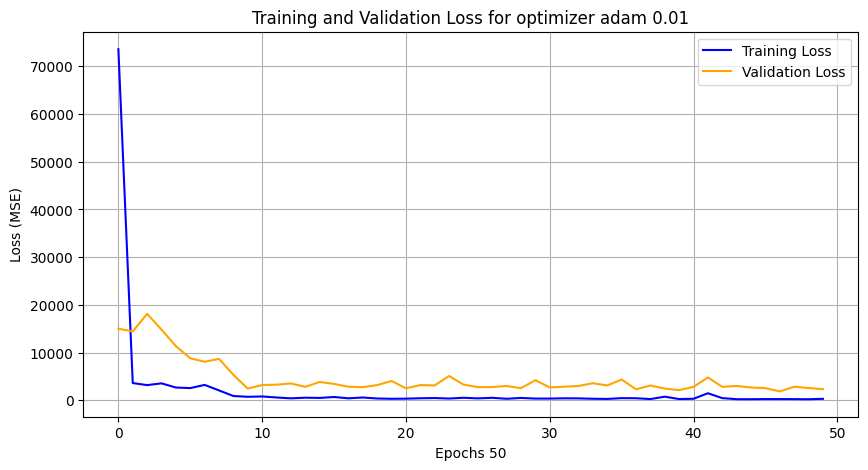

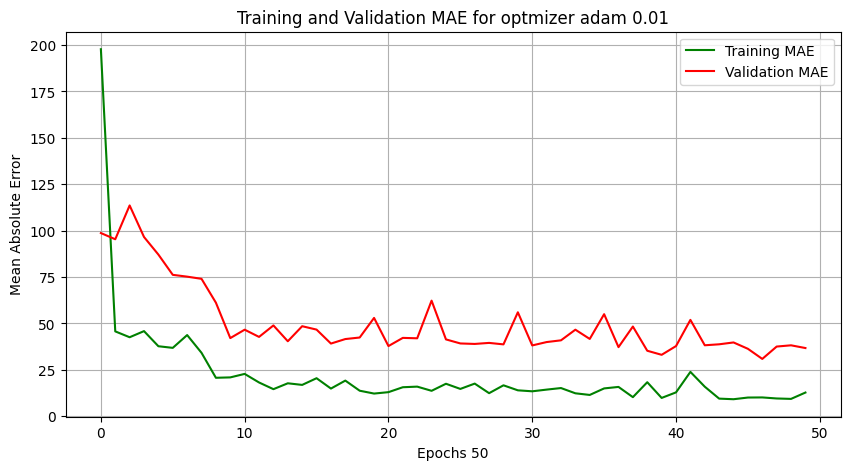

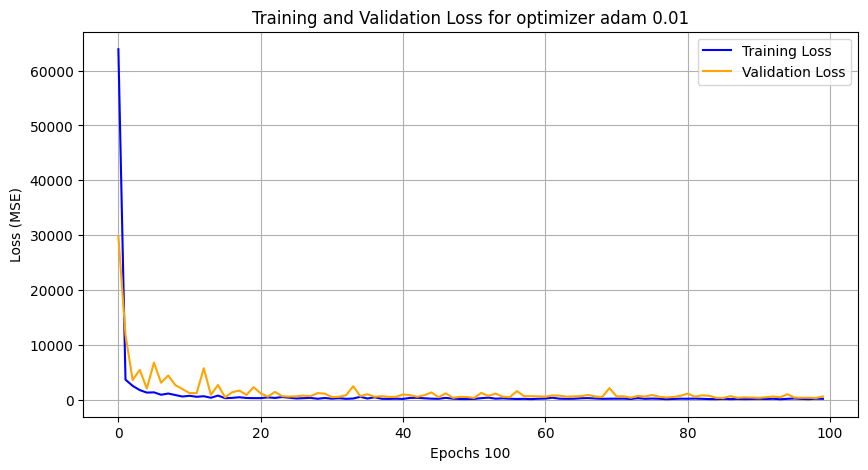

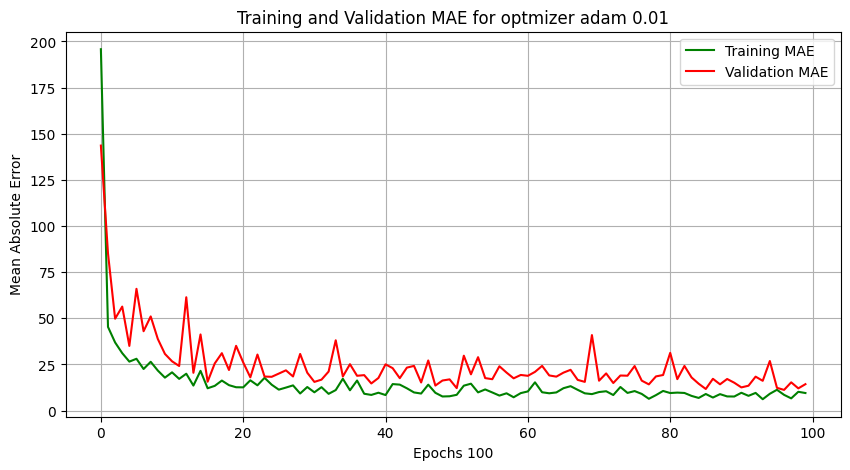

In [ ]:
import matplotlib.pyplot as plt

# List of histories and corresponding number of LSTM units
histories = [history_epoch50,history_epoch100]
epoch = [50,100]  # Update to match your actual models

for history, n in zip(histories, epoch):
    # Plot: Loss (Train + Val)
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title(f'Training and Validation Loss for optimizer adam 0.01')
    plt.xlabel(f'Epochs {n}')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Check if MAE was tracked — only possible if you specified metrics=['mae'] during compile
    if 'mae' in history.history:
        plt.figure(figsize=(10, 5))
        plt.plot(history.history['mae'], label='Training MAE', color='green')
        plt.plot(history.history['val_mae'], label='Validation MAE', color='red')
        plt.title(f'Training and Validation MAE for optmizer adam 0.01')
        plt.xlabel(f'Epochs {n}')
        plt.ylabel('Mean Absolute Error')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print(f"⚠️ MAE metric not available for epoch={n}. Add `metrics=['mae']` in model.compile() if needed.")

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test).flatten()

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / np.maximum(y_test, 1e-10))) * 100

    print(f"📊 {name} Metrics:")
    print(f" - R²:   {r2:.4f}")
    print(f" - RMSE: {rmse:.4f}")
    print(f" - MAE:  {mae:.4f}")
    print(f" - MAPE: {mape:.2f}%\n")

# Evaluate all three models
evaluate_model(model_epoch50, X_test_cnn, y_test, name="LSTM Model (epoch 50 )")
evaluate_model(model_epoch100, X_test_cnn, y_test, name="LSTM Model (epoch 100)")

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 248ms/step
📊 LSTM Model (epoch 50 ) Metrics:
 - R²:   0.7917
 - RMSE: 49.2468
 - MAE:  34.7334
 - MAPE: 24.93%

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step
📊 LSTM Model (epoch 100) Metrics:
 - R²:   0.8953
 - RMSE: 34.9124
 - MAE:  11.1546
 - MAPE: 8.38%



LSTM Model (epoch 20) Metrics:

- R²: 0.7321
- RMSE: 55.8412
- MAE: 47.7430
- MAPE: 29.57%

epoch 50 works best , epoch 100 may be overfitting

**batch size**
- 16 already used previously

32 ->

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam

# Define the model with 4 LSTM layers
model_batch32 = Sequential()
model_batch32.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])))
model_batch32.add(LSTM(128, activation='relu', return_sequences=True))  # Second LSTM layer
model_batch32.add(LSTM(128, activation='relu', return_sequences=True))  # Third LSTM layer
model_batch32.add(LSTM(128, activation='relu'))  # Fourth LSTM layer (no return_sequences)

# Dense layer without activation initially
model_batch32.add(Dense(32))
# Apply LeakyReLU activation
model_batch32.add(LeakyReLU(alpha=0.01))

model_batch32.add(Dense(1))  # Output layer

# Compile the model
optimizer_batch32 = Adam(learning_rate=0.01)
model_batch32.compile(optimizer=optimizer_batch32, loss='mse', metrics=['mae'])

# Train the model
history_batch32 = model_batch32.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 154ms/step - loss: 163282.9531 - mae: 382.2384 - val_loss: 20310.6152 - val_mae: 112.5105
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 19676.1992 - mae: 111.8475 - val_loss: 37139.4219 - val_mae: 160.5041
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4249.4956 - mae: 45.6858 - val_loss: 7949.5864 - val_mae: 75.7263
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1995.3981 - mae: 30.6497 - val_loss: 6467.4829 - val_mae: 70.7391
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1725.7799 - mae: 30.1858 - val_loss: 2982.3284 - val_mae: 42.7804
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2143.8638 - mae: 34.2938 - val_loss: 8173.2271 - val_mae: 71.1281
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1308.0535 - mae: 27.3289 - val_loss: 3755.9329 - val_mae: 48.9263
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 954.9746 - mae: 22.2744 - val_loss: 6540.1650 - val_mae: 62.1023
Ep

48->

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam

# Define the model with 4 LSTM layers
model_batch48 = Sequential()
model_batch48.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])))
model_batch48.add(LSTM(128, activation='relu', return_sequences=True))  # Second LSTM layer
model_batch48.add(LSTM(128, activation='relu', return_sequences=True))  # Third LSTM layer
model_batch48.add(LSTM(128, activation='relu'))  # Fourth LSTM layer (no return_sequences)

# Dense layer without activation initially
model_batch48.add(Dense(32))
# Apply LeakyReLU activation
model_batch48.add(LeakyReLU(alpha=0.01))

model_batch48.add(Dense(1))  # Output layer

# Compile the model
optimizer_batch48 = Adam(learning_rate=0.01)
model_batch48.compile(optimizer=optimizer_batch48, loss='mse', metrics=['mae'])

# Train the model
history_batch48 = model_batch48.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=50,
    batch_size=48,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 153ms/step - loss: 340901.8750 - mae: 441.8853 - val_loss: 72756.8203 - val_mae: 236.3161
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 110326.4844 - mae: 303.5771 - val_loss: 11221.1914 - val_mae: 86.4597
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 15317.1396 - mae: 104.7980 - val_loss: 11301.7285 - val_mae: 87.6385
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3359.6423 - mae: 44.7967 - val_loss: 13927.6494 - val_mae: 94.3888
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3224.4094 - mae: 43.6076 - val_loss: 13946.9492 - val_mae: 94.4111
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3278.8796 - mae: 43.1873 - val_loss: 12970.4189 - val_mae: 91.0494
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2865.7742 - mae: 41.0458 - val_loss: 14747.8057 - val_mae: 97.2358
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3104.4902 - mae: 41.9317 - val_loss: 14769.9795 

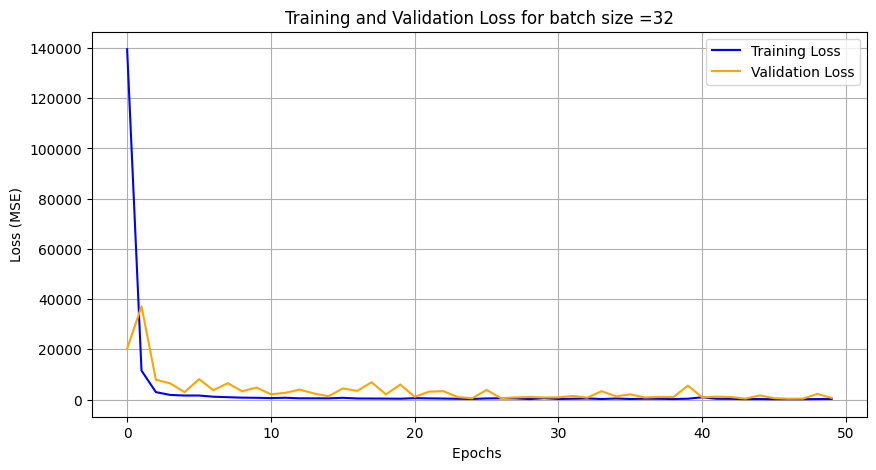

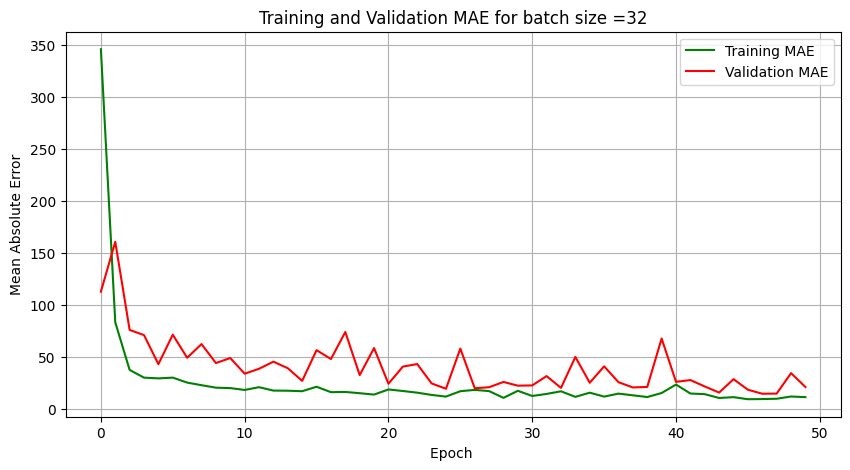

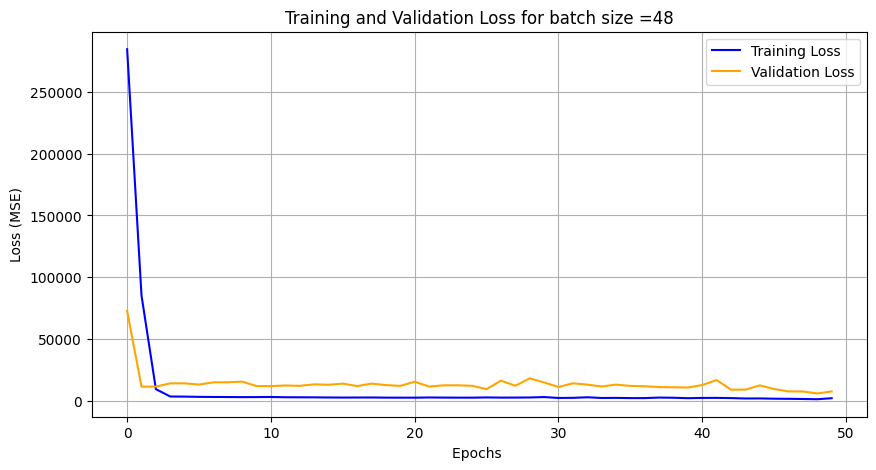

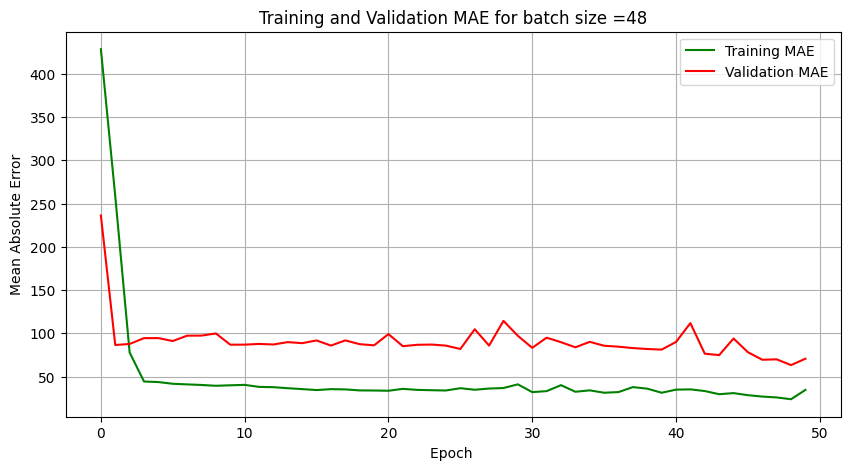

In [ ]:
import matplotlib.pyplot as plt

# List of histories and corresponding number of LSTM units
histories = [history_batch32,history_batch48]
batch_s = [32,48]  # Update to match your actual models

for history, n in zip(histories, batch_s):
    # Plot: Loss (Train + Val)
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title(f'Training and Validation Loss for batch size ={n}')
    plt.xlabel(f'Epochs ')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Check if MAE was tracked — only possible if you specified metrics=['mae'] during compile
    if 'mae' in history.history:
        plt.figure(figsize=(10, 5))
        plt.plot(history.history['mae'], label='Training MAE', color='green')
        plt.plot(history.history['val_mae'], label='Validation MAE', color='red')
        plt.title(f'Training and Validation MAE for batch size ={n}')
        plt.xlabel(f'Epoch ')
        plt.ylabel('Mean Absolute Error')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print(f"⚠️ MAE metric not available for batch size={n}. Add `metrics=['mae']` in model.compile() if needed.")

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test).flatten()

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / np.maximum(y_test, 1e-10))) * 100

    print(f"📊 {name} Metrics:")
    print(f" - R²:   {r2:.4f}")
    print(f" - RMSE: {rmse:.4f}")
    print(f" - MAE:  {mae:.4f}")
    print(f" - MAPE: {mape:.2f}%\n")

# Evaluate all three models
evaluate_model(model_batch32, X_test_cnn, y_test, name="LSTM Model (batch 32 )")
evaluate_model(model_batch48, X_test_cnn, y_test, name="LSTM Model (batch 48)")

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 318ms/step
📊 LSTM Model (batch 32 ) Metrics:
 - R²:   0.8873
 - RMSE: 36.2213
 - MAE:  18.5867
 - MAPE: 12.76%



7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step
📊 LSTM Model (batch 48) Metrics:
 - R²:   0.3670
 - RMSE: 85.8387
 - MAE:  66.5185
 - MAPE: 48.04%



LSTM Model (batch size 16) Metrics:
 - R²:   0.7917
 - RMSE: 49.2468
 - MAE:  34.7334
 - MAPE: 24.93%


**32 is best batch size**

final model is :

4 LSTM layer

128 units

ReLU + leakyRelu activation

Adam optimizer with learning rate = 0.01

MSE loss

50 epochs

Batch size = 32